# May 8th, 2021

**Motivation**: Recap, summary figures. </br>

In [1]:
# HIDE CODE


import re
import os
import sys
import collections
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from os.path import join as pjoin
from scipy import stats as sp_stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


# GitHub
git_path = pjoin(os.environ['HOME'], 'Dropbox/git/Ca-fMRI/')
sys.path.insert(0, git_path)
from simulation.simulation import *
from utils.plotting import *
from utils.processing import *
from model.configuration import Config

In [171]:
# HIDE CODE


def filter_islands(partition, atlas, node_labels, min_com_size: int = 3):
    coms_ctr = collections.Counter(partition.values())
    
    good_com_idxs = zip(*filter(lambda x: x[1] > min_com_size, coms_ctr.most_common()))
    good_com_idxs = sorted(tuple(good_com_idxs)[0])
    bad_com_idxs = [item for item in set(partition.values()) if item not in good_com_idxs]

    comm_dict = collections.defaultdict(list)
    for k, v in partition.items():
        comm_dict[v].append(k)
    comm_dict = dict(sorted(comm_dict.items()))

    comm_mat = np.ones(atlas.shape) * -1
    for node, com_idx in partition.items():
        region_id = node_labels[node]
        if com_idx in good_com_idxs:
            comm_mat[atlas == region_id] = good_com_idxs.index(com_idx)
        else:
            comm_mat[atlas == region_id] = np.nan
    
    output = {
        'good_com_idxs': good_com_idxs,
        'bad_com_idxs': bad_com_idxs,
        'comm_dict': comm_dict,
        'comm_mat': comm_mat,
    }
    return output


def plot_louvain_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    modularities: dict,
    selected_idxs: list,
    pearson_th: float = 0.8,
    spearman_th: float = 0.7,
    min_com_size: int = 3,
    figsize=(12, 4.5),
    colorbar=False, ):

    x0, y0 = tuple(zip(*modularities.items()))
    best_idx = np.argmax(y0)
    best_res = x0[best_idx]
    
    sns.set_style('white')
    plot_idxs = sorted(selected_idxs + [best_idx])
    fig, axes = plt.subplots(2, len(plot_idxs), figsize=figsize)

    for ii, idx in enumerate(plot_idxs):
        # pearson
        g = nx.from_numpy_matrix(pearson[pearson_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[0, ii].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[0, ii], shrink=0.7)
        msg = 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[0, ii].set_title(msg, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[spearman_th])
        coms = cdlib_algorithms.louvain(
            g_original=g,
            weight='weight',
            resolution=x0[idx],
            randomize=False,
        )
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=min_com_size)
        q = nx_comm.modularity(g, communities=coms.communities)
    
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[1, ii].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[1, ii], shrink=0.7)
        msg = 'res = {:.3f}\n\nQ = {:.3f},  # com = {:d}'
        msg = msg.format(x0[idx], q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[1, ii].set_title(msg, y=1.03)
        

        if ii == 0:
            axes[0, ii].set_ylabel('pearson\n(th = {:.2f})\n'.format(pearson_th), fontsize=12)
            axes[1, ii].set_ylabel('spearman\n(th = {:.2f})\n'.format(spearman_th), fontsize=12)
            
        for j in range(2):
            axes[j, ii].set_xticks([])
            axes[j, ii].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



def plot_leiden_communities(
    pearson: dict,
    spearman: dict,
    atlas: np.ndarray,
    contour: np.ndarray,
    figsize=None,
    colorbar=False,):
    
    thresholds = list(spearman.keys())
    
    sns.set_style('white')
    figsize = (5.2, 2*len(thresholds)) if figsize is None else figsize
    fig, axes = plt.subplots(len(thresholds), 2, figsize=figsize)

    for ii, th in enumerate(sorted(thresholds, reverse=True)):
        # pearson
        g = nx.from_numpy_matrix(pearson[th])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)

        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 0].imshow(data2plot, cmap='Spectral_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 0], shrink=0.9)
        if ii == 0:
            msg = 'Pearson\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 0].set_title(msg, fontsize=10, y=1.03)
        
        # spearman
        g = nx.from_numpy_matrix(spearman[th])
        coms = cdlib_algorithms.leiden(g, weights='weight')
        partition = convert('community', 'partition', community=coms.communities)
        output = filter_islands(partition, atlas, node_labels, min_com_size=3)
        q = nx_comm.modularity(g, communities=coms.communities)
        
        data2plot = np.ma.masked_where(contour, output['comm_mat'])
        im = axes[ii, 1].imshow(data2plot, cmap='RdYlBu_r', interpolation='none')
        if colorbar:
            plt.colorbar(im, ax=axes[ii, 1], shrink=0.9)
        if ii == 0:
            msg = 'Spearman\n\n'
        else:
            msg = ''
        msg += 'Q = {:.3f},  # com = {:d}'
        msg = msg.format(q, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))
        axes[ii, 1].set_title(msg, fontsize=10, y=1.03)
        axes[ii, 1].set_ylabel('th = {:.2f}\n'.format(th), fontsize=10)
        
        for j in range(2):
            axes[ii, j].set_xticks([])
            axes[ii, j].set_yticks([])

    fig.tight_layout()
    plt.show()
    
    return fig, axes



from skimage.feature import canny
import functools


def organize_atlas(organized_data: dict, include: List = None, config: Config = None):
    config = Config() if config is None else config
    regions = np.unique(organized_data['atlas'])
    regions = {i: config.region_labels[i] for i in regions if i > 0}
    
    include = [i for i in regions if i < 24] if include is None else include
    exclude = [item for item in regions if item not in include]
    mapping = {i+1: regions[item].split('(')[0].strip() for i, item in enumerate(include)}

    atlas = organized_data['atlas'].copy().astype(float)
    cond = functools.reduce(np.logical_or, [atlas == r for r in exclude])
    x = np.ma.masked_where(cond, atlas)

    for i, true_i in zip(mapping, include):
        x[x == true_i] = i

    mapping[0] = 'background'
    mapping = dict(sorted(mapping.items()))

    contour = atlas.copy()
    for i, true_i in enumerate(regions):
        contour[contour == true_i] = i
    contour = canny(contour, sigma=1e-10)
    y = np.ma.masked_where(contour, x)

    output = {
        'regions': regions,
        'mapping': mapping,
        'atlas_limited': x,
        'contour': contour,
        'atlas_masked': y,
    }
    return output

## Allen atlas visualization

In [3]:
config = Config()

num_regions = 256
subject = 6
session = 1
run = 1

load = load_organized_data(
    folder='atlas-{:d}_unfiltered_unnormalized'.format(num_regions),
    config=config,
    subject=subject,
    session=session,
    run=run,
)

In [4]:
atls_org = organize_atlas(load)

In [5]:
atls_org['regions']

{2: 'R-Primary motor area (MOp,985)',
 3: 'R-Secondary motor area (MOs,993)',
 4: 'R-Primary somatosensory area, nose (SSp-n,353)',
 5: 'R-Primary somatosensory area, barrel field (SSp-bfd,329)',
 6: 'R-Primary somatosensory area, lower limb (SSp-ll,337)',
 7: 'R-Primary somatosensory area, mouth (SSp-m,345)',
 8: 'R-Primary somatosensory area, upper limb (SSp-ul,369)',
 9: 'R-Primary somatosensory area, trunk (SSp-tr,361)',
 10: 'R-Primary somatosensory area, unassigned (SSp-un,182305689)',
 11: 'R-Supplemental somatosensory area (SSs,378)',
 14: 'R-Dorsal auditory area (AUDd,1011)',
 15: 'R-Primary auditory area (AUDp,1002)',
 16: 'R-Posterior auditory area (AUDpo,1027)',
 18: 'R-Anterolateral visual area (VISal,402)',
 19: 'R-Anteromedial visual area (VISam,394)',
 20: 'R-Lateral visual area (VISl,409)',
 21: 'R-Primary visual area (VISp,385)',
 22: 'R-Posterolateral visual area (VISpl,425)',
 23: 'R-posteromedial visual area (VISpm,533)',
 24: 'R-Anterior area (VISa,312782546)',
 2

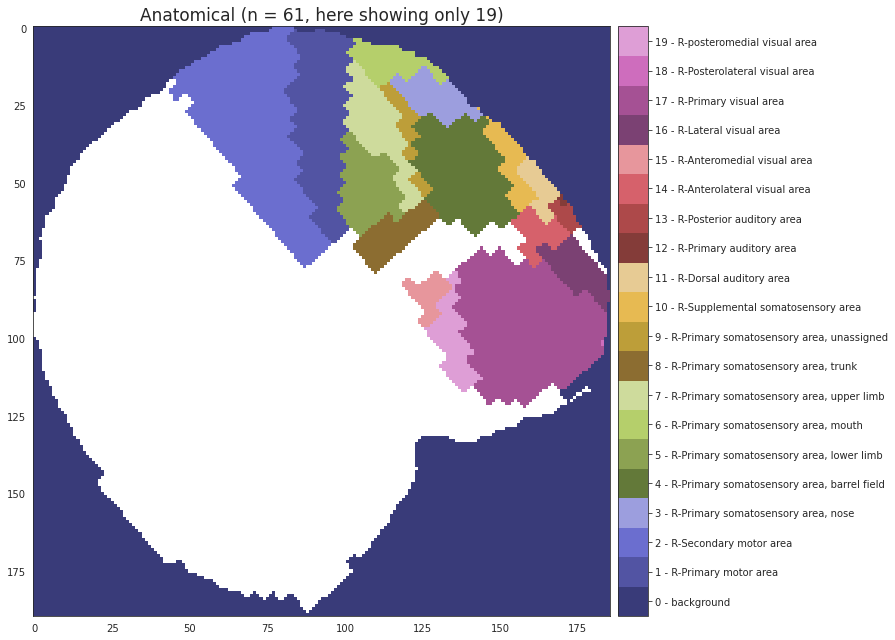

In [6]:
fig, ax = plt.subplots(figsize=(13.5, 9))
vmin = min(atls_org['mapping']) - 0.5
vmax = len(atls_org['mapping']) - 0.5
cax = ax.imshow(atls_org['atlas_limited'], cmap='tab20b', interpolation='none', vmin=vmin, vmax=vmax)

msg = 'Anatomical (n = {:d}, here showing only {:d})'
msg = msg.format(len(atls_org['regions']), len(atls_org['mapping']) - 1)
plt.title(msg, fontsize=17)

cbar = fig.colorbar(cax, ticks=[item for item in atls_org['mapping']], pad=0.01)
tick_labels = ['{:d} - {:s}'.format(k, v) for k, v in atls_org['mapping'].items()]
cbar.ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()

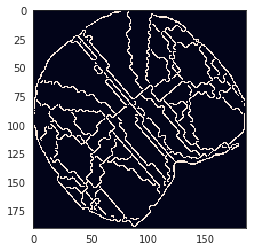

In [7]:
plt.imshow(atls_org['contour'], interpolation='none')

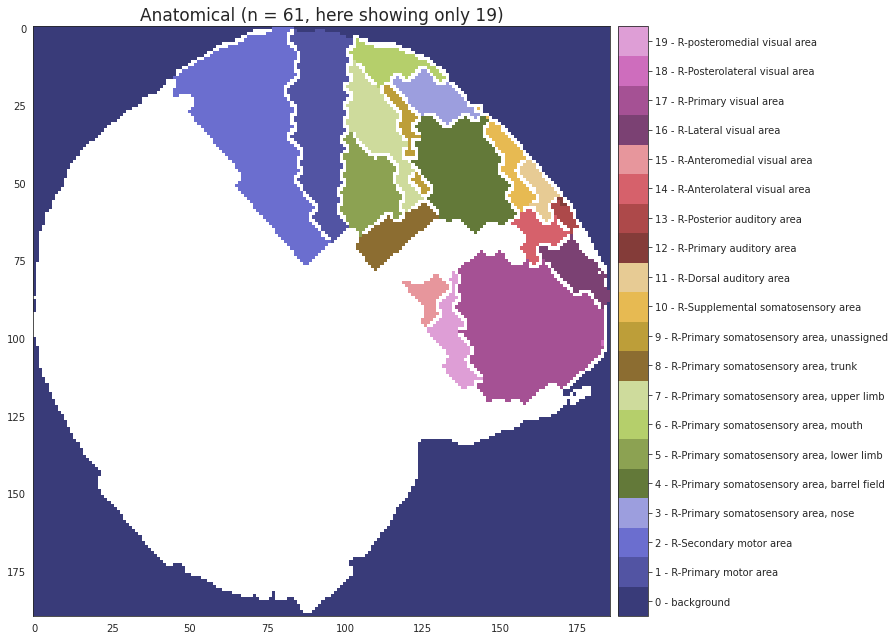

In [8]:
fig, ax = plt.subplots(figsize=(13.5, 9))
vmin = min(atls_org['mapping']) - 0.5
vmax = len(atls_org['mapping']) - 0.5
cax = ax.imshow(atls_org['atlas_masked'], cmap='tab20b', interpolation='none', vmin=vmin, vmax=vmax)

msg = 'Anatomical (n = {:d}, here showing only {:d})'
msg = msg.format(len(atls_org['regions']), len(atls_org['mapping']) - 1)
plt.title(msg, fontsize=17)

cbar = fig.colorbar(cax, ticks=[item for item in atls_org['mapping']], pad=0.01)
tick_labels = ['{:d} - {:s}'.format(k, v) for k, v in atls_org['mapping'].items()]
cbar.ax.set_yticklabels(tick_labels)

fig.tight_layout()
plt.show()

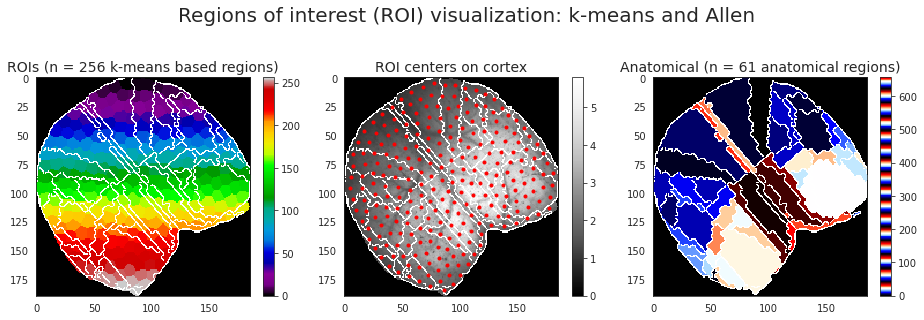

In [9]:
sns.set_style('white')
plt.figure(figsize=(13, 4.5))
plt.subplot(131)
plt.imshow(np.ma.masked_where(atls_org['contour'], load['atlas_kmeans']),
           cmap='nipy_spectral', interpolation='none')
plt.colorbar(shrink=0.8)
plt.title('ROIs (n = {:d} k-means based regions)'.format(num_regions), fontsize=14)

plt.subplot(132)
plt.imshow(np.ma.masked_where(atls_org['contour'], load['ref']), cmap='Greys_r', interpolation='none')
for j, i in load['kmeans_centers']: 
    plt.plot(i, j, marker='o', color='r', markersize=3)
plt.colorbar(shrink=0.8)
plt.title('ROI centers on cortex', fontsize=14)
    
plt.subplot(133)
plt.imshow(np.ma.masked_where(atls_org['contour'], load['atlas']), cmap='flag_r', interpolation='none')
plt.colorbar(shrink=0.8)
plt.title('Anatomical (n = {:d} anatomical regions)'.format(len(atls_org['regions'])), fontsize=14)

sup = plt.suptitle('Regions of interest (ROI) visualization: k-means and Allen', fontsize=20, y=1.01)
plt.tight_layout()

# plt.savefig('kmeans_atlas_{:d}.pdf'.format(num_regions), dpi=300, bbox_inches='tight', bbox_extra_artists=[sup])
plt.show()

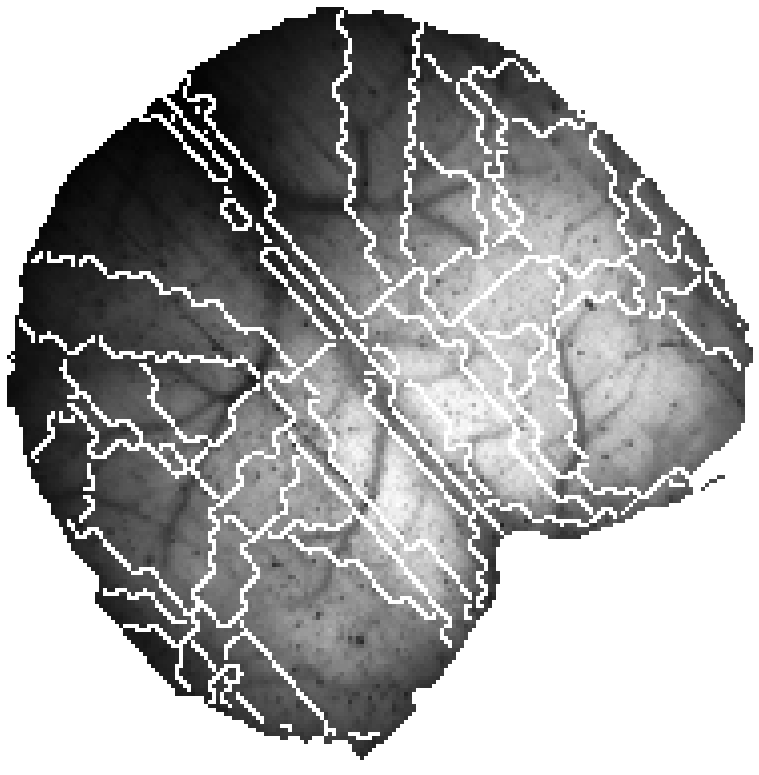

In [13]:
sns.set_style('white')
plt.figure(figsize=(18, 14))
cond = np.logical_or(atls_org['contour'], load['atlas'] == 0)
plt.imshow(np.ma.masked_where(cond, load['ref']), cmap='Greys_r', interpolation='antialiased')
plt.axis('off')
plt.show()
# plt.colorbar(aspect=40)
# plt.savefig('reference_minimal.pdf', dpi=300, bbox_inches='tight')

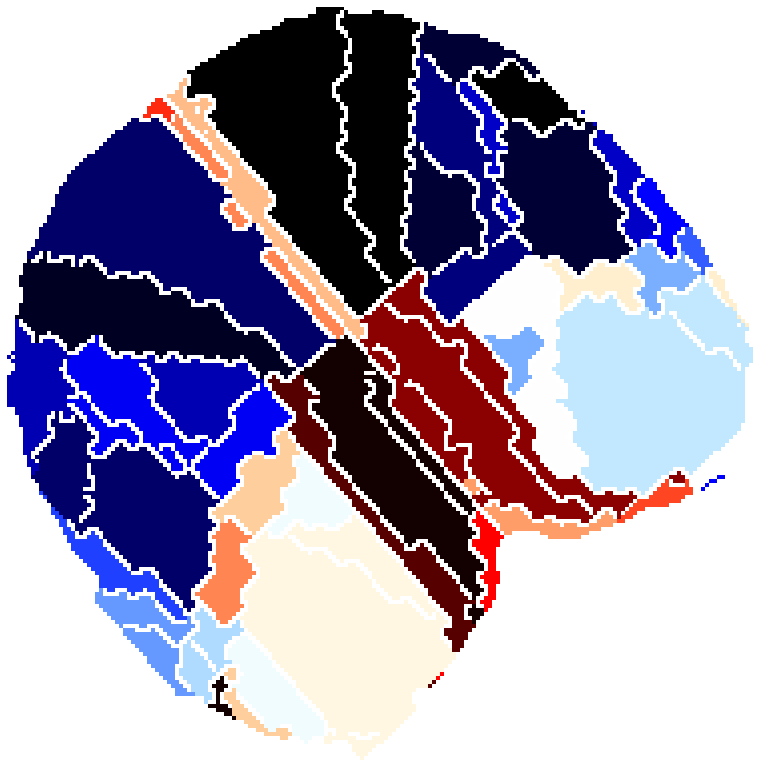

In [11]:
sns.set_style('white')
plt.figure(figsize=(18, 14))
cond = np.logical_or(atls_org['contour'], load['atlas'] == 0)
plt.imshow(np.ma.masked_where(cond, load['atlas']), cmap='flag_r', interpolation='none')
plt.axis('off')
plt.show()
# lt.colorbar(aspect=40)
# plt.savefig('atlas.pdf', dpi=300, bbox_inches='tight')

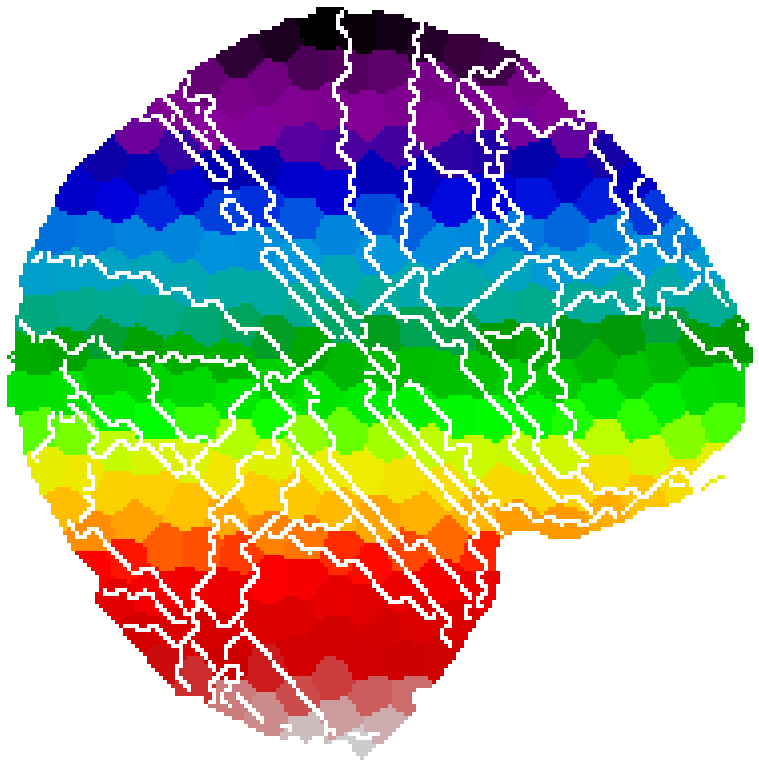

In [14]:
sns.set_style('white')
plt.figure(figsize=(18, 14))
cond = np.logical_or(atls_org['contour'], load['atlas'] == 0)
plt.imshow(np.ma.masked_where(cond, load['atlas_kmeans']),
           cmap='nipy_spectral', interpolation='none')
# plt.colorbar(aspect=40)
plt.axis('off')
plt.show()
# plt.savefig('kmeans_atlas_{:d}_2.pdf'.format(num_regions), dpi=300, bbox_inches='tight')

## Allen parcellation, community structure

In [15]:
data_all = {}
df = pd.DataFrame()
for run in [1, 3, 5, 7]:
    _load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    data_all[run] = _load
    
    # normalize
    mean = np.mean([item.mean() for item in _load['ca'].values()])
    sd = np.mean([item.std() for item in _load['ca'].values()])
    _ca = {k: (v - mean) / sd for k, v in _load['ca'].items()}
    _df = pd.DataFrame.from_dict(_ca)
    df = pd.concat([df, _df])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

2             3             4             5             6    \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.016470     -0.018240     -0.015282     -0.003259      0.018897   
std        0.629801      0.466723      0.633126      1.220131      1.269930   
min       -2.448160     -1.950162     -2.127644     -4.117877     -4.076775   
25%       -0.428421     -0.314127     -0.452591     -0.845619     -0.833966   
50%       -0.013142     -0.018966     -0.032826     -0.029985     -0.019495   
75%        0.394903      0.269910      0.394358      0.798206      0.849160   
max        3.802673      3.315142      3.156683      6.369267      7.755381   

                7             8             9             10            11   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.016037     -0.006291      0.048155     -0.008254     -0.008132   
std        0.422778      0.965836      1.928495      1.074744      0.832809   
min       -1.576220     -3.272419     -5.927036     -3.740386     -2.652617   
25%       -0.302064     -0.657687     -1.265214     -0.746149     -0.587083   
50%       -0.023853     -0.025799     -0.030234     -0.033669     -0.029572   
75%        0.258890      0.634490      1.285492      0.703723      0.531091   
max        1.860840      4.785238     10.427175      5.674547      4.721781   

       ...           525           526           528           530  \
count  ...  22000.000000  22000.000000  22000.000000  22000.000000   
mean   ...     -0.034107     -0.016903     -0.004136     -0.017237   
std    ...      0.504141      1.087339      0.399043      0.179432   
min    ...     -1.935170     -3.434844     -1.546170     -0.726891   
25%    ...     -0.369868     -0.762635     -0.247245     -0.137745   
50%    ...     -0.033002     -0.035239     -0.019736     -0.017527   
75%    ...      0.291316      0.696168      0.213845      0.094695   
max    ...      2.633923      5.843461      5.597064      1.116010   

                538           539           540           541           655  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       0.028251      0.064408      0.062204     -0.034549      0.025482   
std        1.688213      2.205852      1.665477      0.457557      0.849909   
min       -6.097915     -7.547431     -7.089397     -1.765626     -3.180276   
25%       -0.986188     -1.292455     -0.975689     -0.338368     -0.521417   
50%        0.096717      0.158215      0.079588     -0.030011      0.022124   
75%        1.122999      1.448869      1.011084      0.264375      0.525521   
max       12.347784     16.508649     19.975790      2.203298     11.461152   

                656  
count  22000.000000  
mean      -0.015245  
std        0.637300  
min       -2.387982  
25%       -0.421664  
50%       -0.026428  
75%        0.365549  
max        6.242416  

[8 rows x 61 columns]

In [62]:
thresholds = [0.78, 0.79, 0.80, 0.81, 0.82, 0.83]
corrs = get_corrs(df, thresholds=thresholds)

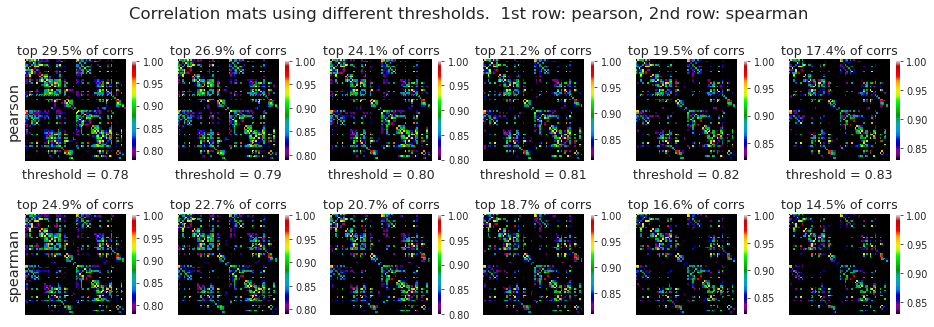

In [63]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

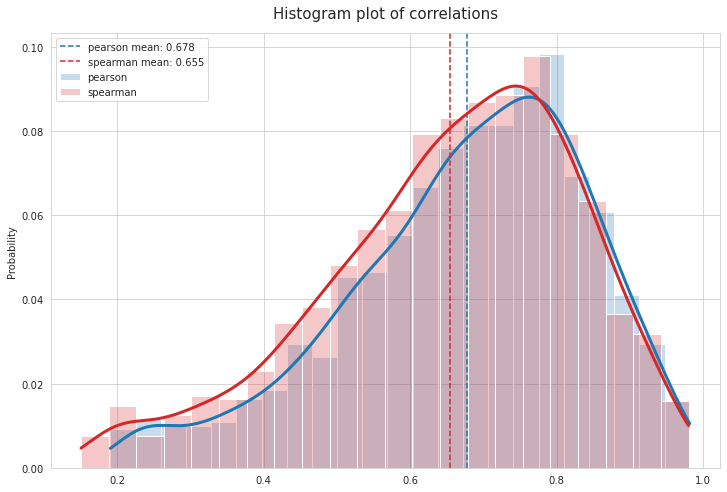

In [64]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

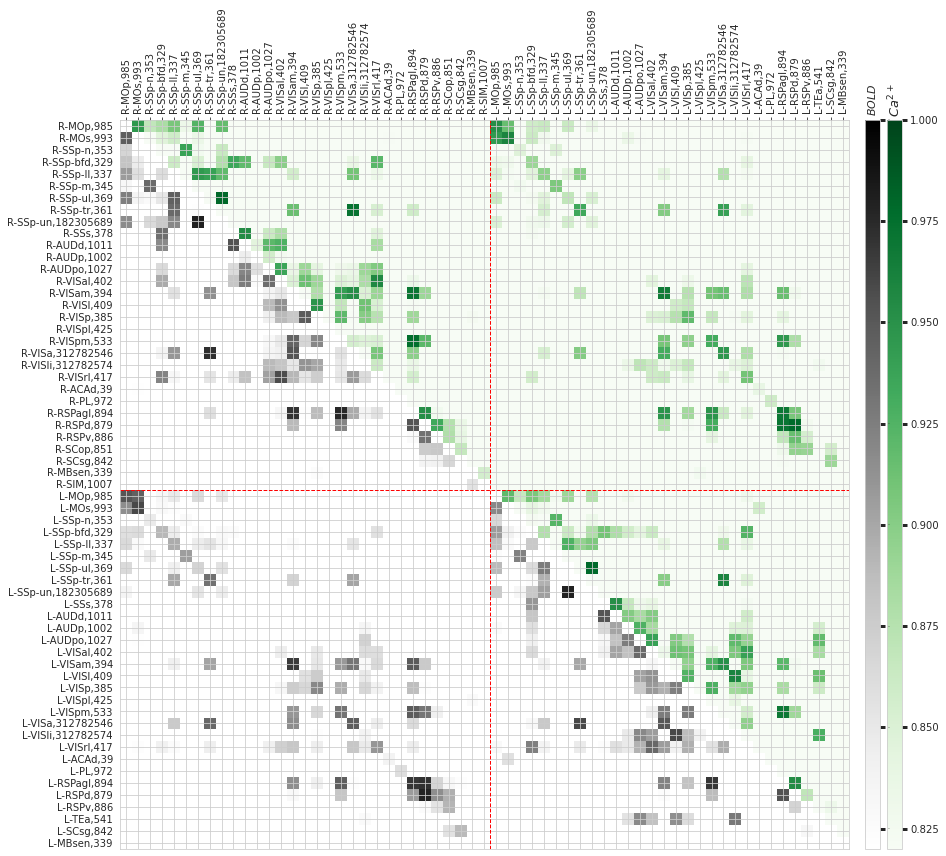

In [65]:
th = 0.82
data1 = corrs['spearman'][th].copy()
data2 = corrs['spearman'][th].copy()

lower = np.tril_indices(len(atls_org['regions']))
upper = np.triu_indices(len(atls_org['regions']))

data1[lower] = np.nan
data2[upper] = np.nan

ticks = []
for i, (region_id, label) in enumerate(atls_org['regions'].items()):
    prefix = label[:2]
    label_short = label.split('(')[1].split(')')[0].strip()
    tick = ''.join([prefix, label_short])
    ticks.append((i, tick))
ticks, tick_labels = zip(*ticks)
boundary_idx = [i[0] != j[0] for i, j in zip(tick_labels, tick_labels[1:])].index(True)

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

im1 = ax.imshow(data1, cmap='Greens', vmin=th, vmax=1)
im2 = ax.imshow(data2, cmap='Greys', vmin=th, vmax=1)

ax.xaxis.tick_top()
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, fontsize=10, rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels, fontsize=10, rotation=0)
ax.xaxis.set_label_position('top')

cax1 = fig.colorbar(im1, aspect=50, ax=ax, pad=-0.126)
cax2 = fig.colorbar(im2, aspect=50, pad=0.015)
cax1.ax.tick_params(labelsize=10, length=5, width=3)
cax2.ax.tick_params(labelsize=0, length=5, width=3)
# cax1.ax.set_xlabel('$Ca^{2+}$', fontsize=18, rotation=-90)
# cax2.ax.set_xlabel('$BOLD$', fontsize=16, rotation=-90)
cax1.ax.set_title('$Ca^{2+}$', fontsize=13, rotation=90)
cax2.ax.set_title('$BOLD$', fontsize=11, rotation=90)

ax.axhline(boundary_idx + 0.5, color='r', ls='--', lw=1)
ax.axvline(boundary_idx + 0.5, color='r', ls='--', lw=1)

fig.tight_layout()
fig.savefig('rsFC_th{:.2f}.pdf'.format(th), dpi=600)
plt.show()

In [66]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

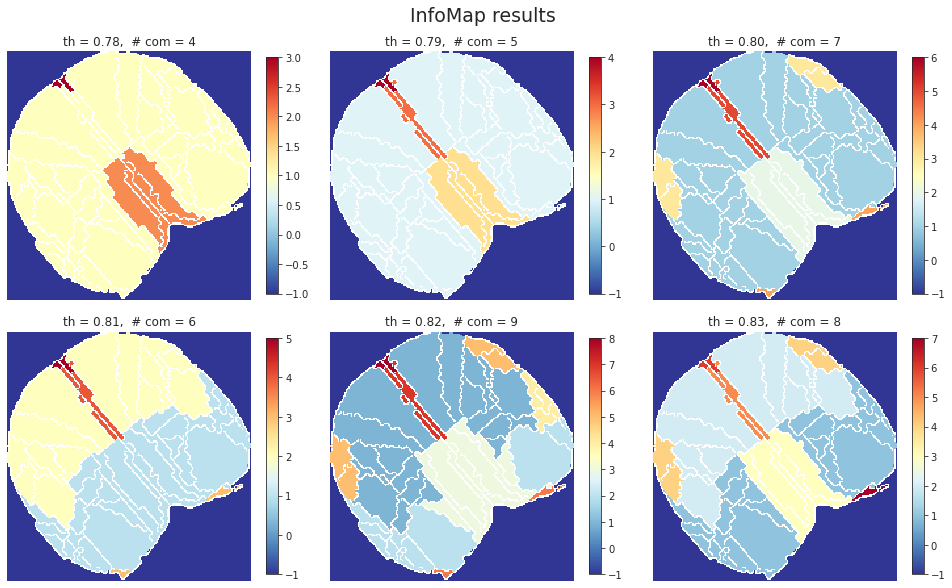

In [78]:
sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8.5))

for idx, (th, g) in enumerate(graphs.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas'], node_labels, min_com_size=0)
    msg = 'th = {:.2f},  # com = {:d}'.format(th, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results', fontsize=19)
fig.tight_layout()    
plt.show()

In [79]:
results_louvain = run_louvain(graphs[0.82], res=np.logspace(-1, 1, 10001))

  0%|          | 0/10001 [00:00<?, ?it/s]

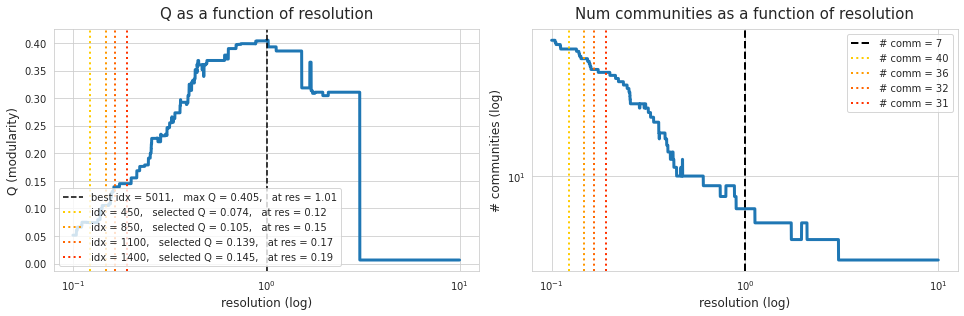

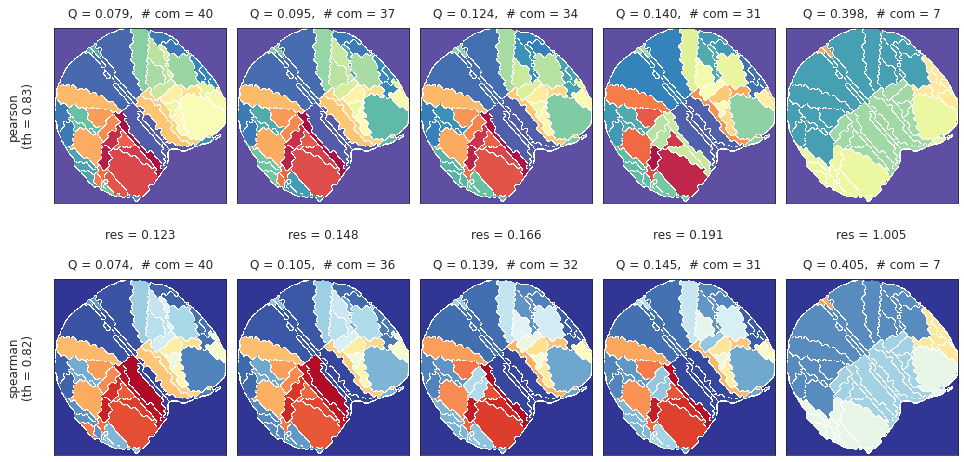

In [118]:
selected_idxs = [450, 850, 1100, 1400]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.83,
    spearman_th=0.82,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

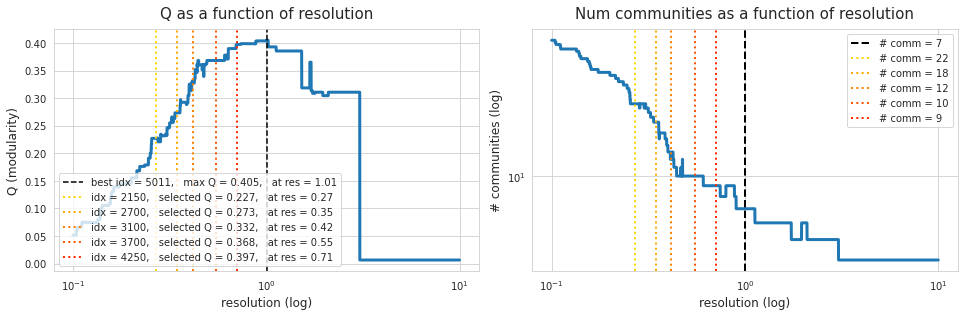

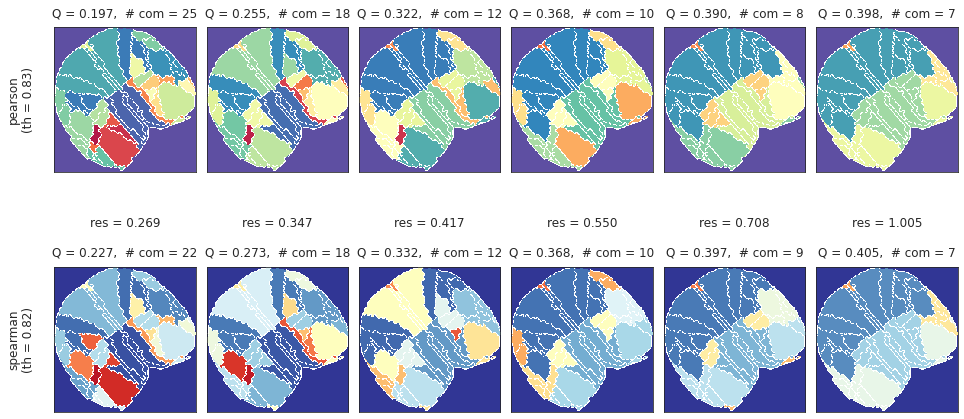

In [120]:
selected_idxs = [2150, 2700, 3100, 3700, 4250]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.83,
    spearman_th=0.82,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

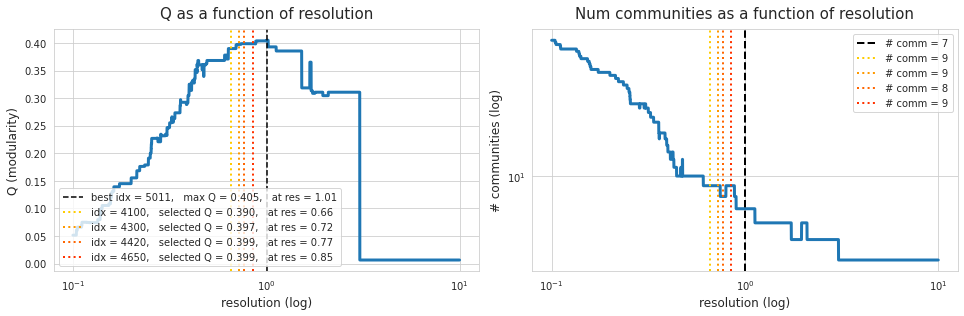

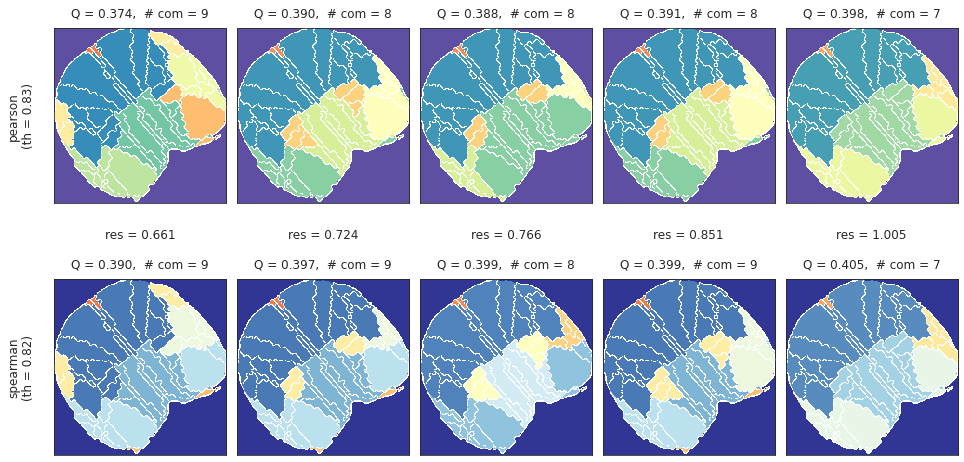

In [132]:
selected_idxs = [4100, 4300, 4420, 4650]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.83,
    spearman_th=0.82,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

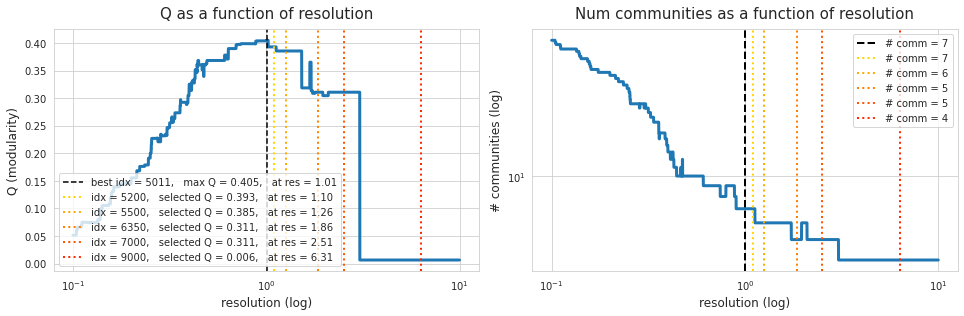

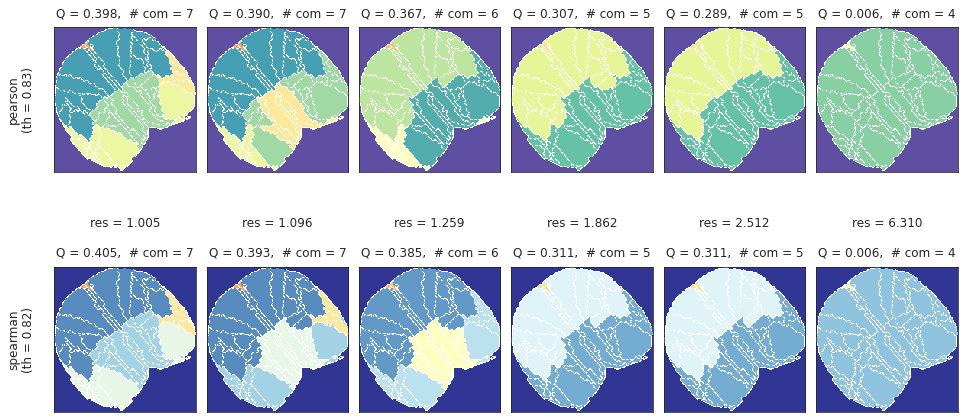

In [145]:
selected_idxs = [5200, 5500, 6350, 7000, 9000]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.83,
    spearman_th=0.82,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

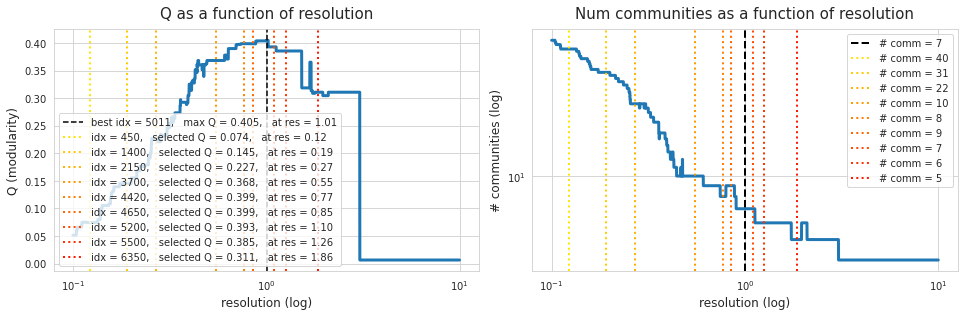

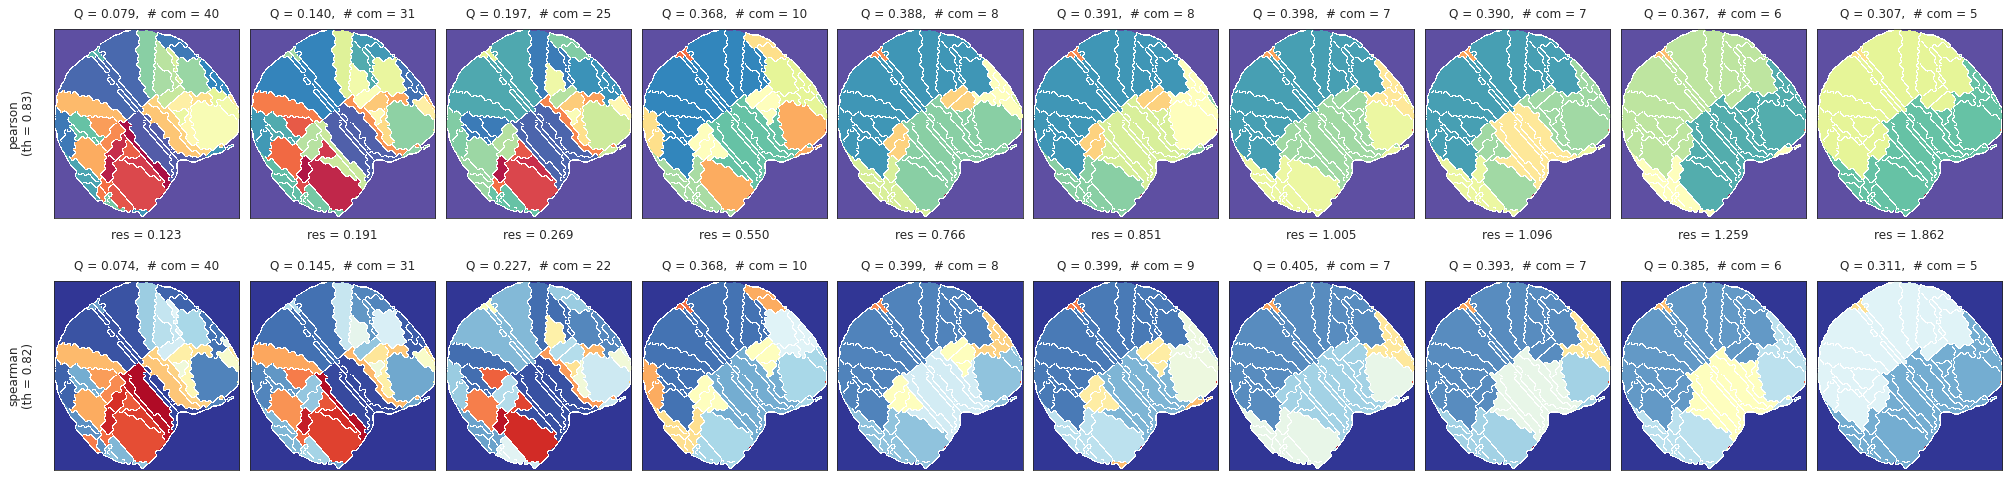

In [167]:
selected_idxs = [450, 1400, 2150, 3700, 4420, 4650, 5200, 5500, 6350]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.83,
    spearman_th=0.82,
    min_com_size=0,
    figsize=(28, 7),
    colorbar=False, )

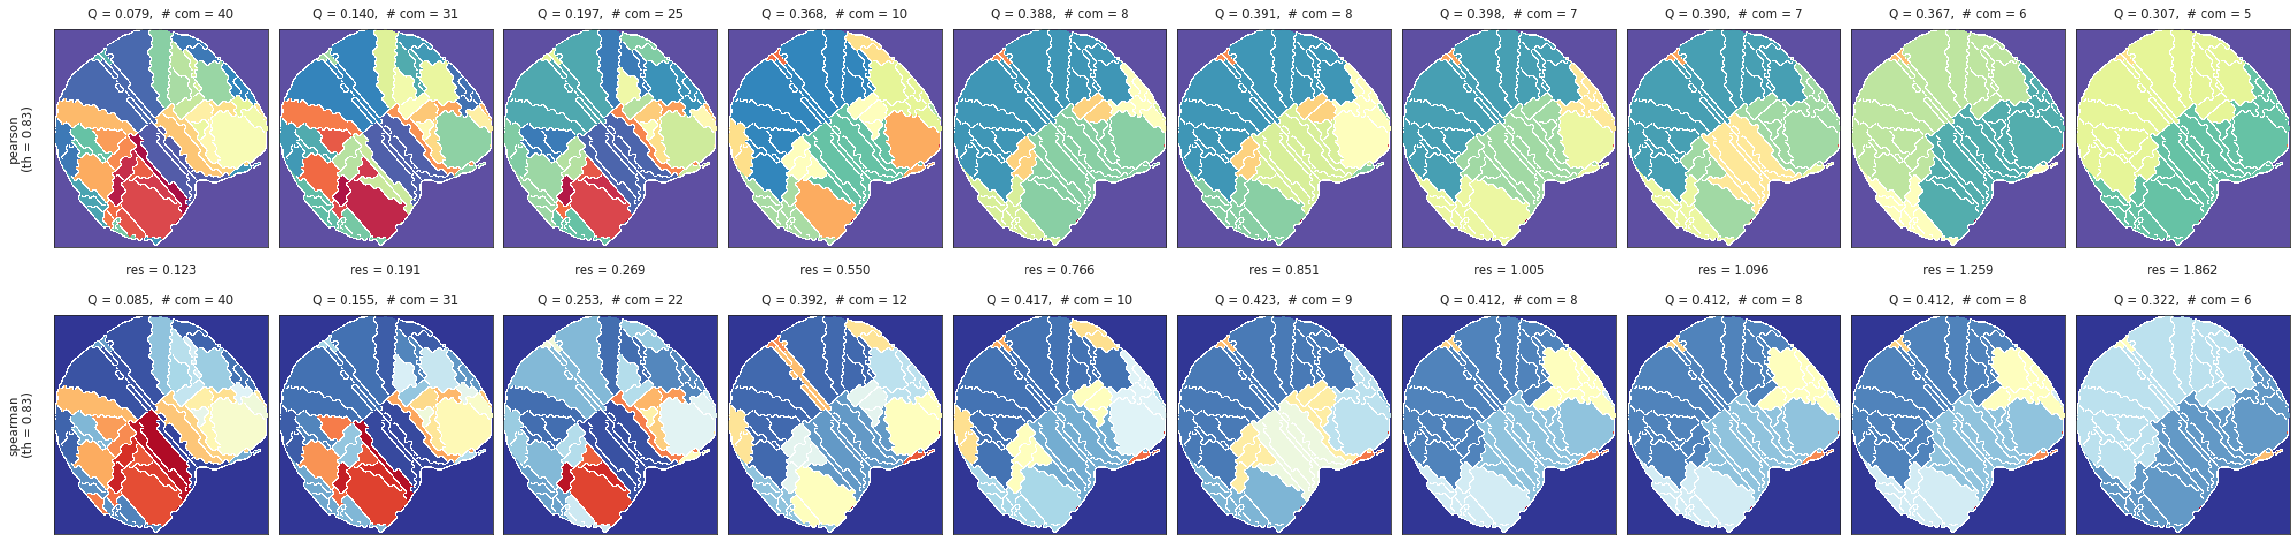

In [169]:
fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    min_com_size=0,
    pearson_th=0.83,
    spearman_th=0.83,
    figsize=(32, 8),
    colorbar=False, )

In [170]:
fig.savefig('LouvainAllen.pdf', dpi=300, bbox_inches='tight')

#### Leiden

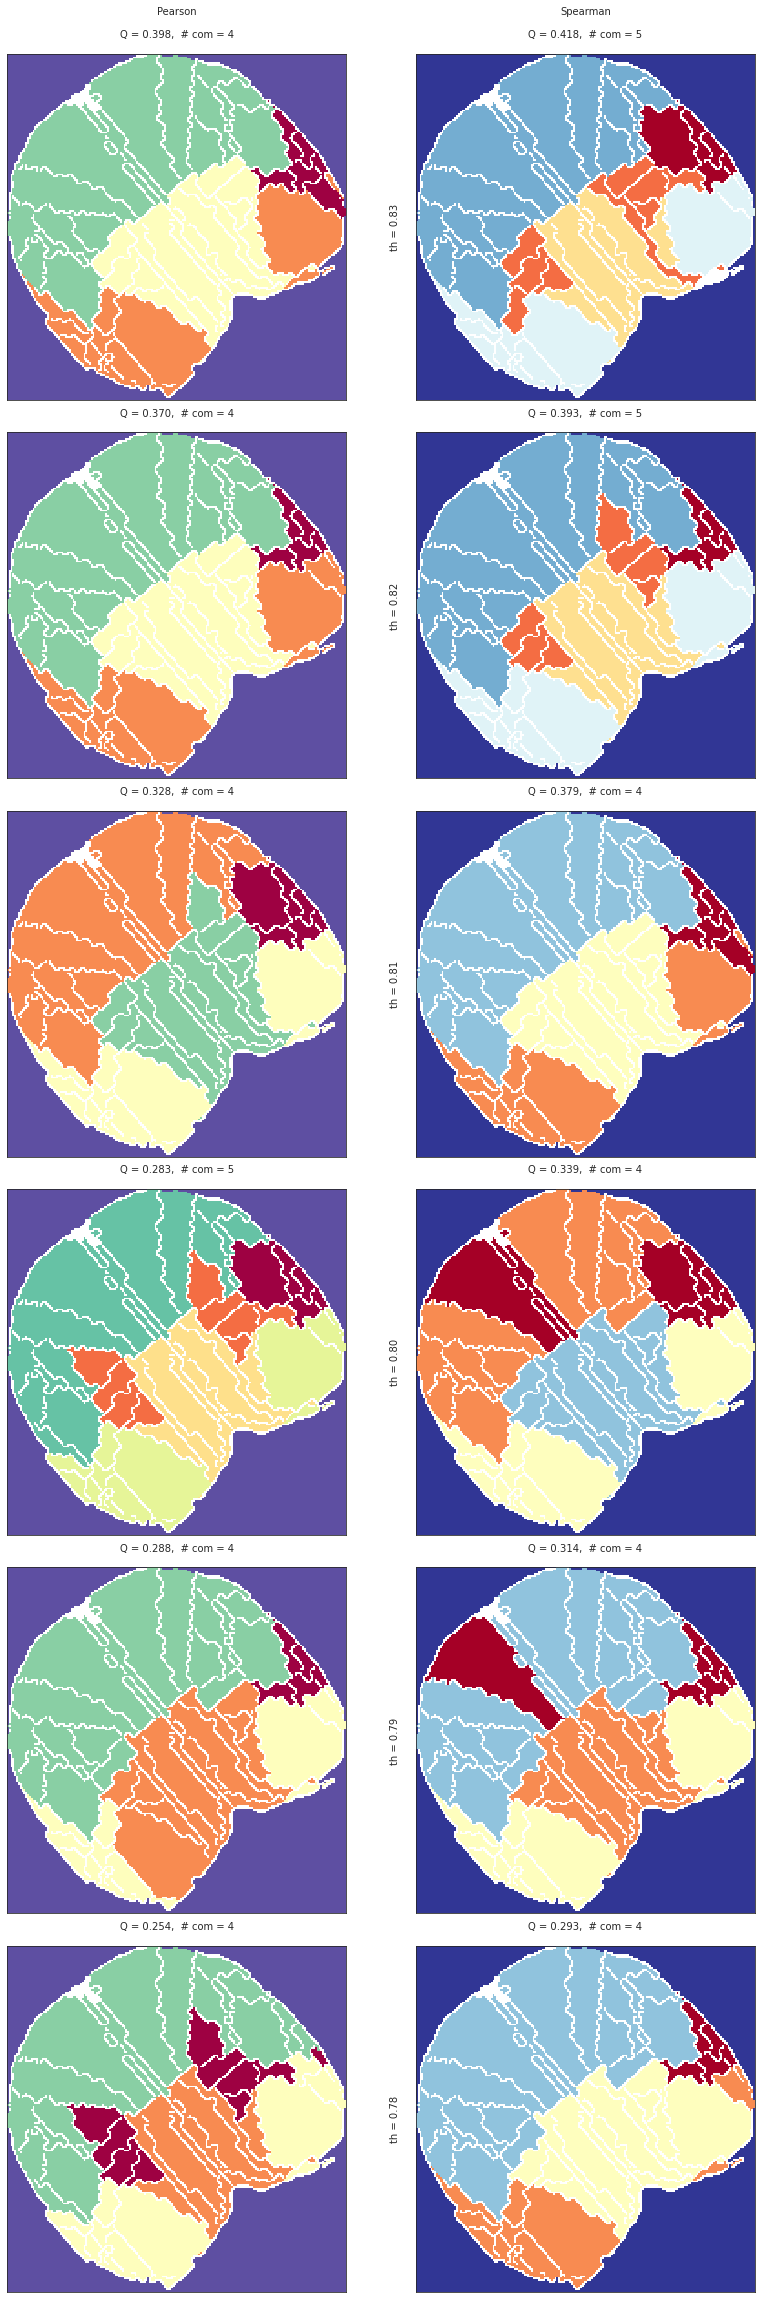

In [178]:
_ = plot_leiden_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    figsize=(12, 32),
    colorbar=False,
)

### Apply bandpass
- lowcut: 0.001
- highcut: 1 Hz

In [180]:
lowcut = 0.001
highcut = 1.000
order = 2

data_all = {}
df = pd.DataFrame()
for run in [1, 3, 5, 7]:
    _load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    
    # bandpass
    ca_bp = {
        k: apply_bandpass(
            x=v,
            fs=config.ca_fs,
            lowcut=lowcut,
            highcut=highcut,
            order=order,
        ) for k, v in _load['ca'].items()
    }
    
    # normalize
    mean = np.mean([item.mean() for item in ca_bp.values()])
    sd = np.mean([item.std() for item in ca_bp.values()])
    ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
    data_all[run] = ca_bp_n
    
    df = pd.concat([df, pd.DataFrame.from_dict(ca_bp_n)])

node_labels = df.columns.values.tolist()
node_labels = {i: lbl for i, lbl in enumerate(node_labels)}

df.describe()

2             3             4             5             6    \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.057985     -0.450497      0.055556      0.659289      0.586134   
std        0.716463      0.541208      0.692234      1.341723      1.455946   
min       -2.347731     -2.164369     -2.012722     -3.645132     -4.668050   
25%       -0.523914     -0.796926     -0.416488     -0.211965     -0.328051   
50%       -0.129833     -0.489316     -0.025008      0.532875      0.451177   
75%        0.393865     -0.107336      0.534430      1.535776      1.399023   
max        2.552898      1.477613      2.514457      6.233777      6.886434   

                7             8             9             10            11   \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean      -0.311016      0.337183      1.039400      0.543304      0.212589   
std        0.500472      1.042675      2.188591      1.178494      0.883200   
min       -1.715509     -3.142744     -6.894933     -3.041446     -2.427072   
25%       -0.682891     -0.328335     -0.288757     -0.209502     -0.413266   
50%       -0.322440      0.229627      0.941306      0.404607      0.114595   
75%        0.052200      0.947346      2.279090      1.244958      0.805876   
max        1.182643      4.450051     10.969767      5.413200      3.536646   

       ...           525           526           528           530  \
count  ...  22000.000000  22000.000000  22000.000000  22000.000000   
mean   ...     -0.431907      0.274488     -0.491854     -0.701672   
std    ...      0.586115      1.139555      0.527634      0.437471   
min    ...     -2.320691     -3.221201     -1.973229     -1.480962   
25%    ...     -0.810206     -0.476504     -0.878055     -1.103257   
50%    ...     -0.497607      0.134560     -0.542254     -0.704791   
75%    ...     -0.067027      0.955086     -0.117894     -0.255436   
max    ...      1.711777      4.662090      2.220831      0.243401   

                538           539           540           541           655  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       0.102028     -0.087520      0.097278     -0.443844     -0.143588   
std        1.530430      2.108989      1.883672      0.529109      1.041351   
min       -4.493791     -6.911257     -5.552175     -2.174657     -3.273786   
25%       -0.933437     -1.491694     -1.107966     -0.794047     -0.872135   
50%       -0.021639     -0.216085     -0.104297     -0.499619     -0.269989   
75%        0.998008      1.062117      0.930672     -0.094538      0.511631   
max        8.099985     11.519101     11.511723      1.552044      5.452697   

                656  
count  22000.000000  
mean      -0.504072  
std        0.688426  
min       -2.463642  
25%       -0.979823  
50%       -0.576889  
75%       -0.109568  
max        2.546522  

[8 rows x 61 columns]

In [186]:
thresholds = [0.70, 0.75, 0.77, 0.78, 0.79, 0.80]
corrs = get_corrs(df, thresholds=thresholds)

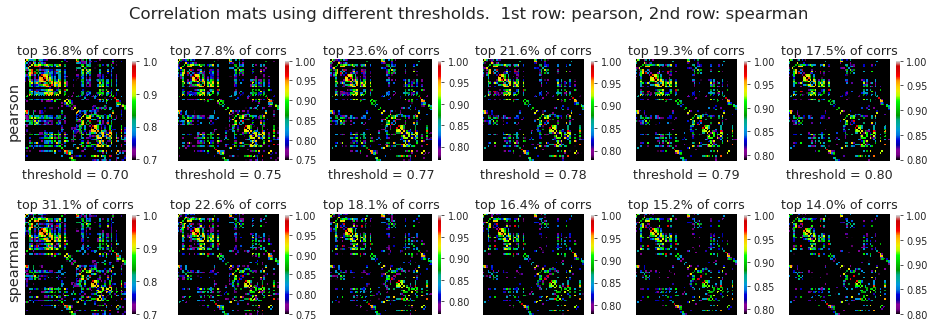

In [187]:
_ = plot_corrs(corrs['pearson'], corrs['spearman'])

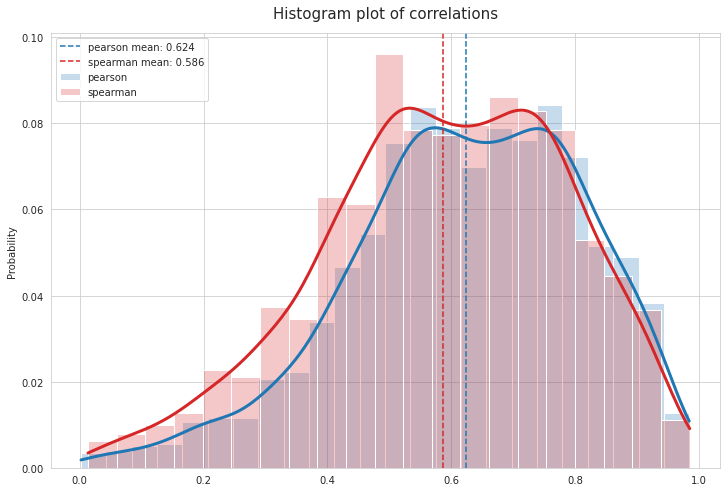

In [188]:
_ = plot_corr_hist(
    corr_list=[corrs['pearson_corr'], corrs['spearman_corr']],
    labels=['pearson', 'spearman'],
    colors=['C0', 'C3'],
)

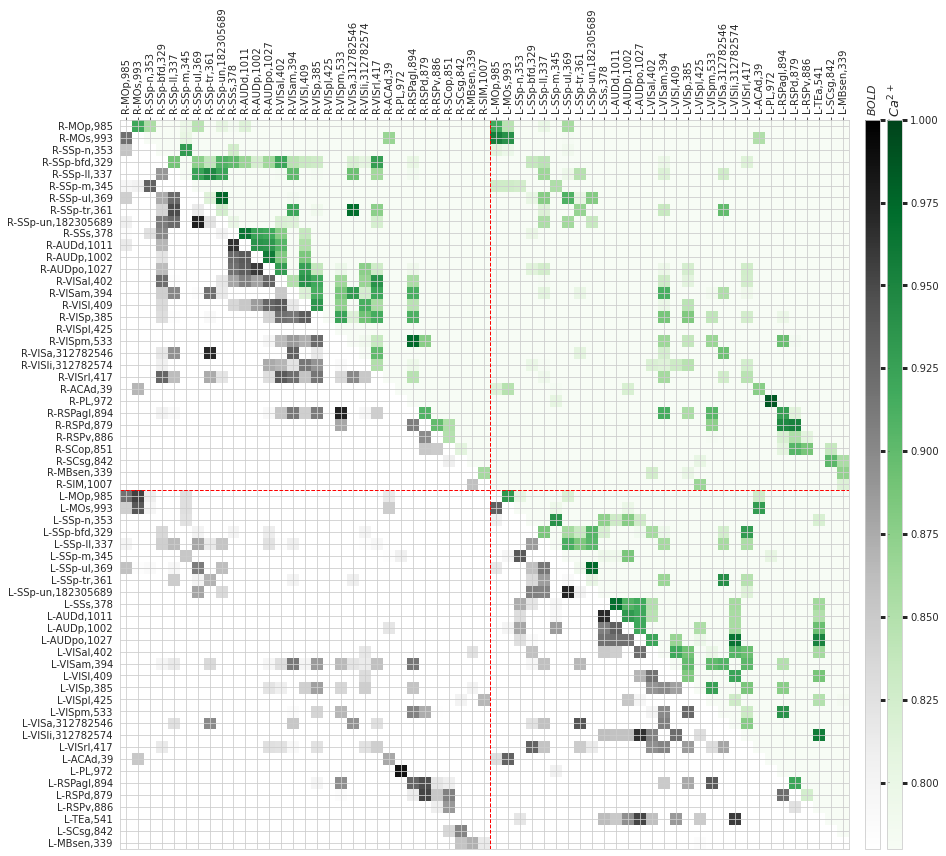

In [189]:
th = 0.78
data1 = corrs['spearman'][th].copy()
data2 = corrs['spearman'][th].copy()

lower = np.tril_indices(len(atls_org['regions']))
upper = np.triu_indices(len(atls_org['regions']))

data1[lower] = np.nan
data2[upper] = np.nan

ticks = []
for i, (region_id, label) in enumerate(atls_org['regions'].items()):
    prefix = label[:2]
    label_short = label.split('(')[1].split(')')[0].strip()
    tick = ''.join([prefix, label_short])
    ticks.append((i, tick))
ticks, tick_labels = zip(*ticks)
boundary_idx = [i[0] != j[0] for i, j in zip(tick_labels, tick_labels[1:])].index(True)

sns.set_style('whitegrid')
fig, ax = plt.subplots(figsize=(16, 12))

im1 = ax.imshow(data1, cmap='Greens', vmin=th, vmax=1)
im2 = ax.imshow(data2, cmap='Greys', vmin=th, vmax=1)

ax.xaxis.tick_top()
ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels, fontsize=10, rotation=90)
ax.set_yticks(ticks)
ax.set_yticklabels(tick_labels, fontsize=10, rotation=0)
ax.xaxis.set_label_position('top')

cax1 = fig.colorbar(im1, aspect=50, ax=ax, pad=-0.126)
cax2 = fig.colorbar(im2, aspect=50, pad=0.015)
cax1.ax.tick_params(labelsize=10, length=5, width=3)
cax2.ax.tick_params(labelsize=0, length=5, width=3)
# cax1.ax.set_xlabel('$Ca^{2+}$', fontsize=18, rotation=-90)
# cax2.ax.set_xlabel('$BOLD$', fontsize=16, rotation=-90)
cax1.ax.set_title('$Ca^{2+}$', fontsize=13, rotation=90)
cax2.ax.set_title('$BOLD$', fontsize=11, rotation=90)

ax.axhline(boundary_idx + 0.5, color='r', ls='--', lw=1)
ax.axvline(boundary_idx + 0.5, color='r', ls='--', lw=1)

fig.tight_layout()
# fig.savefig('rsFC_th{:.2f}.pdf'.format(th), dpi=600)
plt.show()

In [190]:
graphs = {th: nx.from_numpy_matrix(a) for th, a in corrs['spearman'].items()}

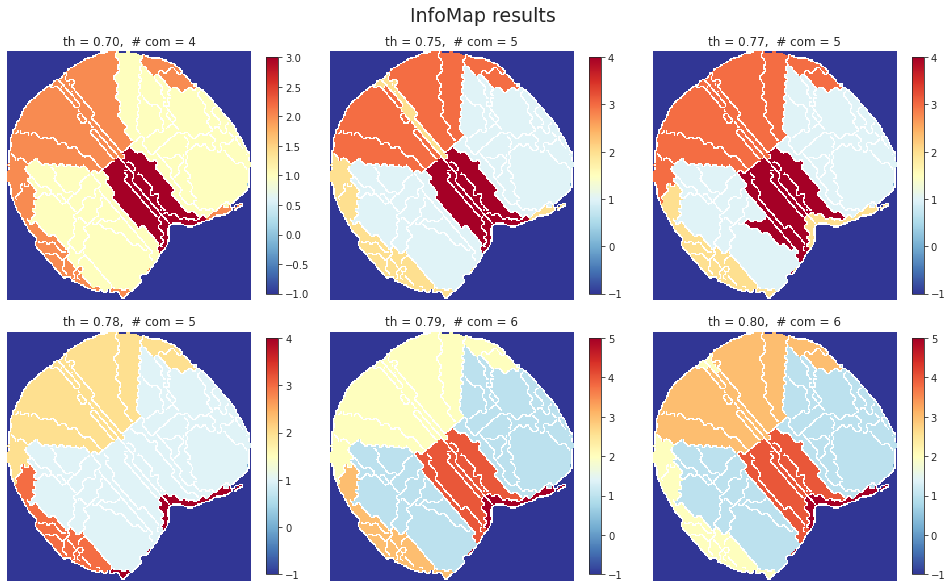

In [191]:
sns.set_style('white')
nrows, ncols = 2, len(graphs)//2
fig, axes = plt.subplots(nrows, ncols, figsize=(13.5, 8.5))

for idx, (th, g) in enumerate(graphs.items()):
    infomap_coms = cdlib_algorithms.infomap(g)
    infomap_community = infomap_coms.communities
    infomap_partition = convert('community', 'partition', community=infomap_community)
    output = filter_islands(infomap_partition, load['atlas'], node_labels, min_com_size=0)
    msg = 'th = {:.2f},  # com = {:d}'.format(th, len(np.unique(output['comm_mat'][output['comm_mat']>-1])))

    i, j = idx//ncols, idx%ncols
    im = axes[i, j].imshow(
        np.ma.masked_where(atls_org['contour'], output['comm_mat']), cmap='RdYlBu_r', interpolation='none')
    axes[i, j].set_title(msg, fontsize=12)
    axes[i, j].axis('off')
    plt.colorbar(mappable=im, ax=axes[i, j], shrink=0.85)

sup = fig.suptitle('InfoMap results', fontsize=19)
fig.tight_layout()    
plt.show()

In [192]:
results_louvain = run_louvain(graphs[0.78], res=np.logspace(-1, 1, 10001))

  0%|          | 0/10001 [00:00<?, ?it/s]

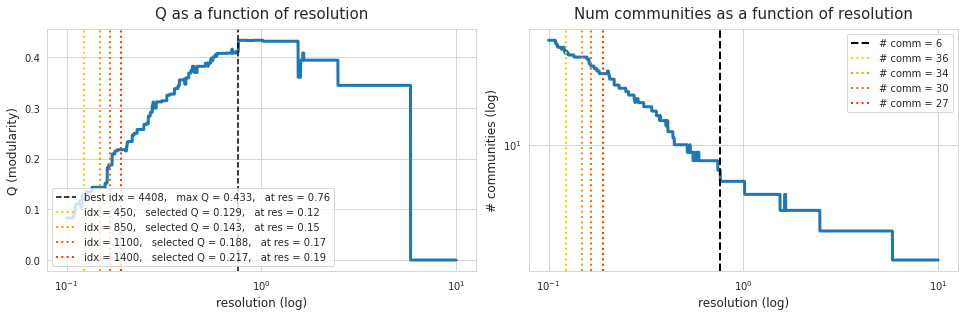

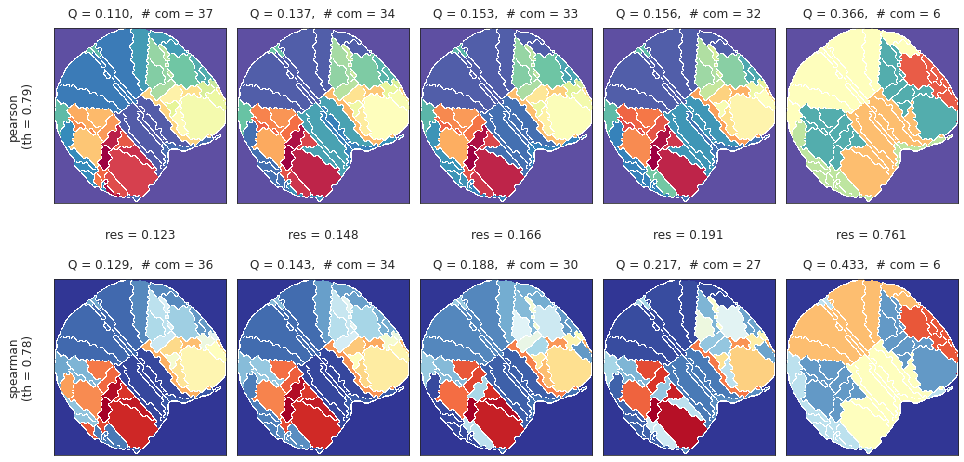

In [194]:
selected_idxs = [450, 850, 1100, 1400]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.79,
    spearman_th=0.78,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

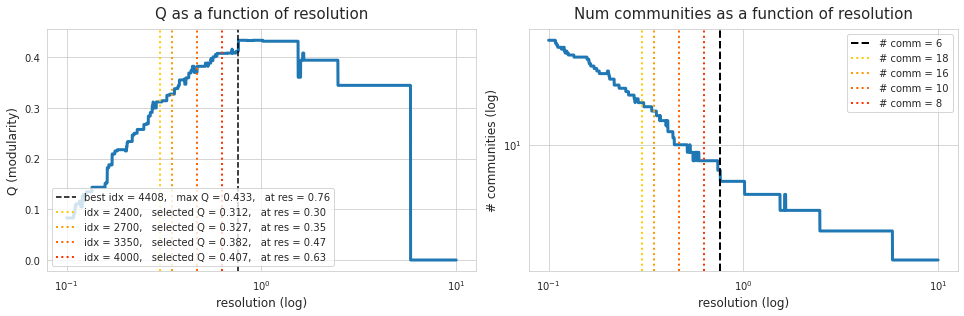

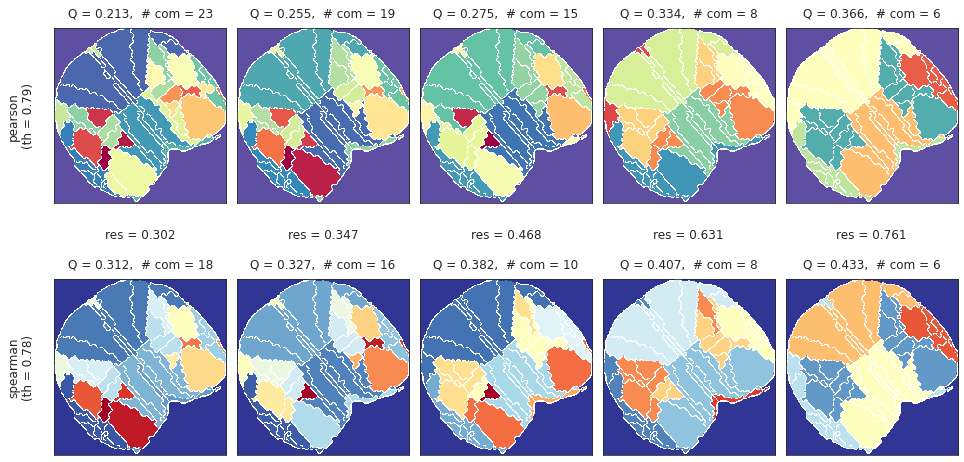

In [204]:
selected_idxs = [2400, 2700, 3350, 4000]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.79,
    spearman_th=0.78,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

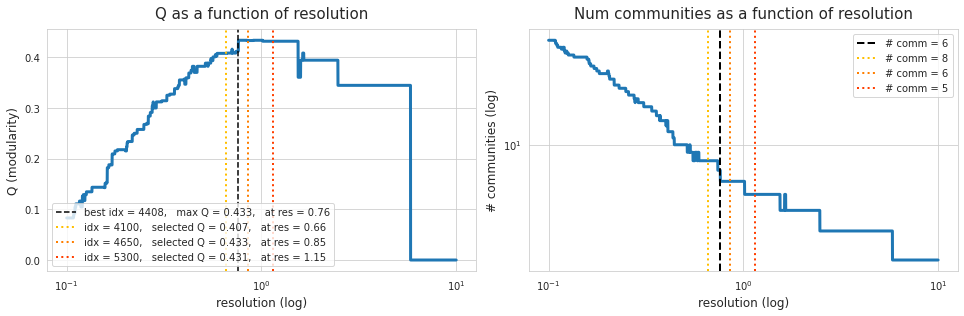

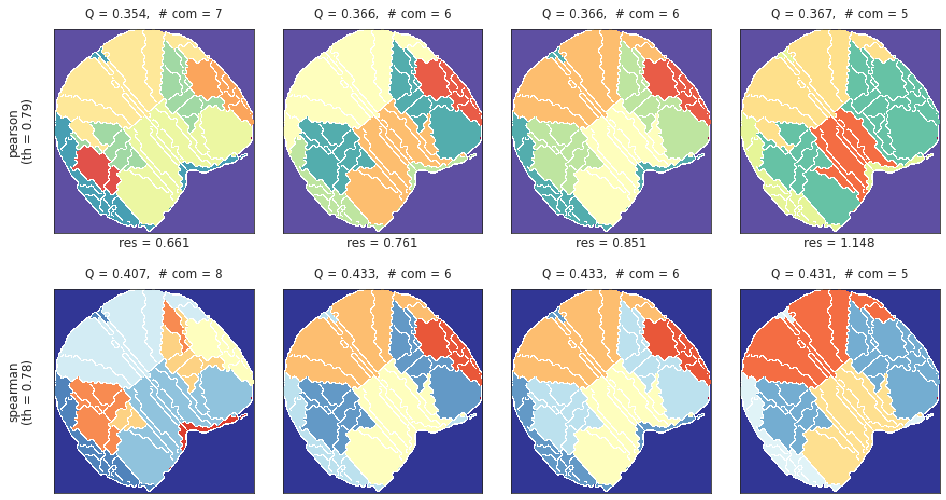

In [217]:
selected_idxs = [4100, 4650, 5300]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.79,
    spearman_th=0.78,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

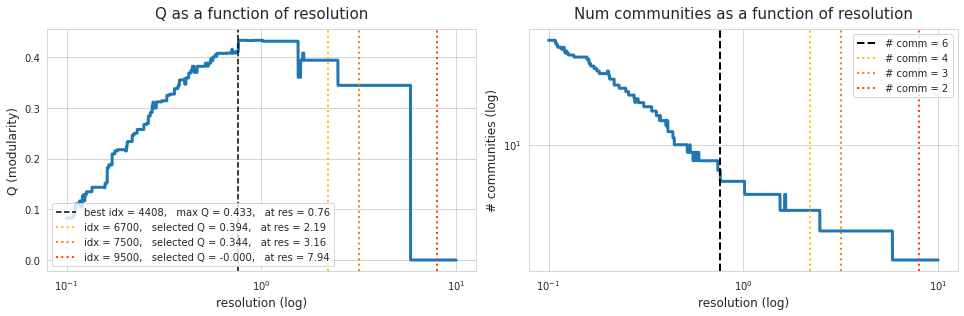

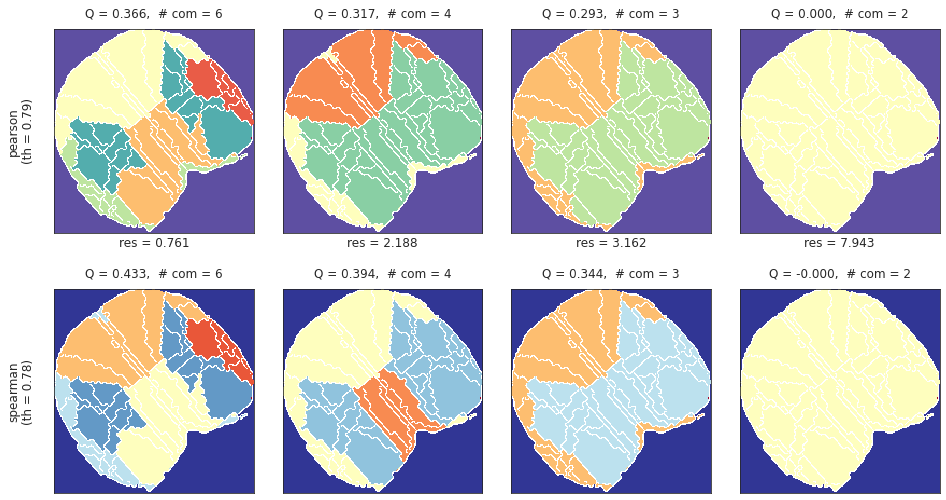

In [219]:
selected_idxs = [6700, 7500, 9500]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.79,
    spearman_th=0.78,
    min_com_size=0,
    figsize=(13.5, 7),
    colorbar=False, )

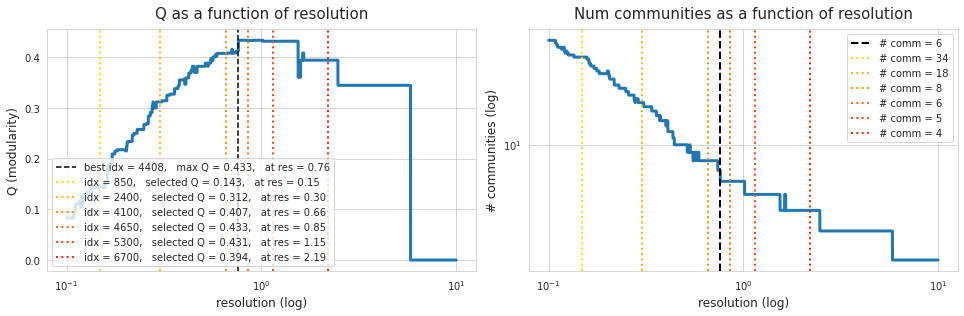

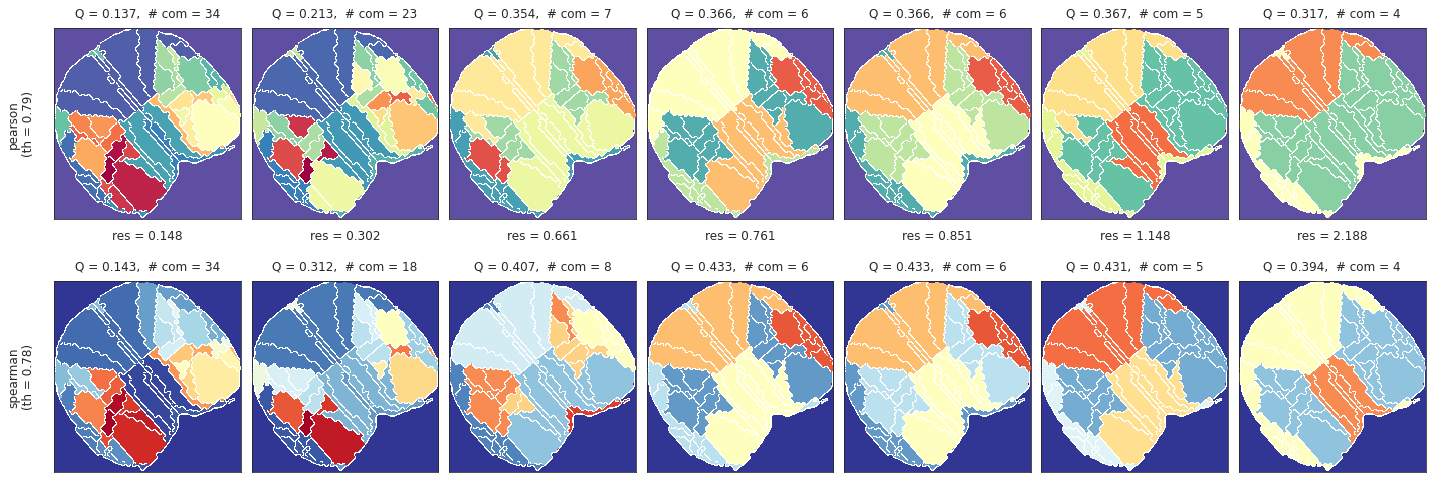

In [222]:
selected_idxs = [850, 2400, 4100, 4650, 5300, 6700]
_ = plot_louvain_results(results_louvain, selected_idxs=selected_idxs)

print('\n')

fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    pearson_th=0.79,
    spearman_th=0.78,
    min_com_size=0,
    figsize=(20, 7),
    colorbar=False, )

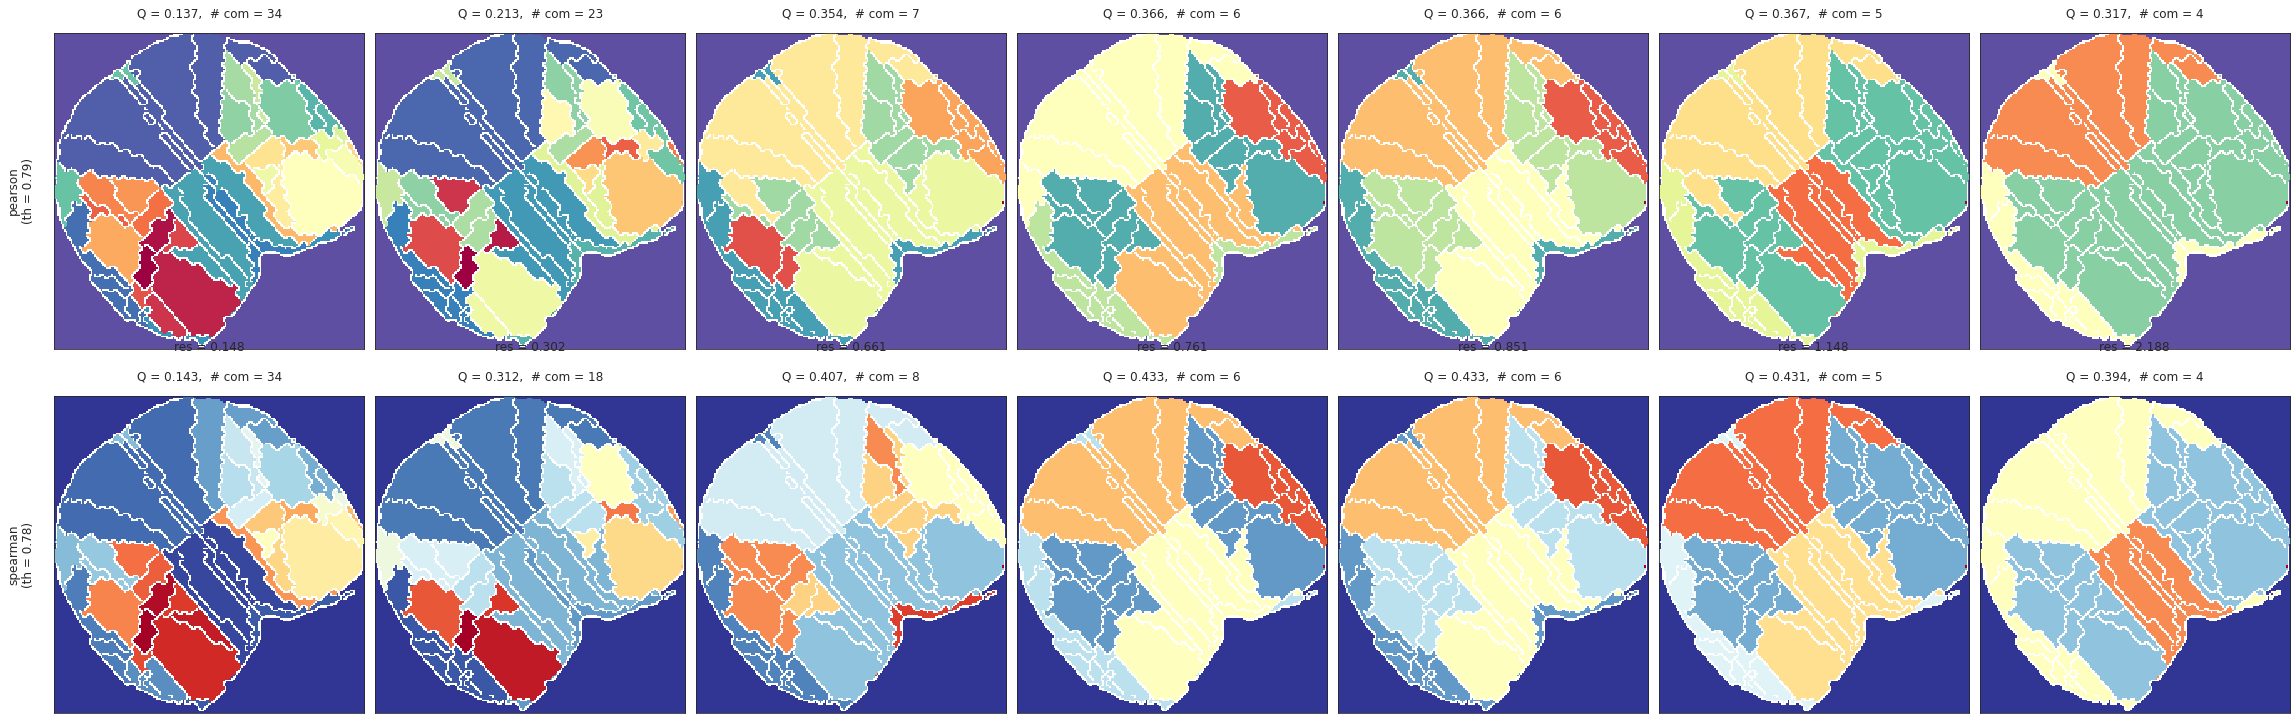

In [224]:
fig, axes = plot_louvain_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    modularities=results_louvain['modularities'],
    selected_idxs=selected_idxs,
    min_com_size=0,
    pearson_th=0.79,
    spearman_th=0.78,
    figsize=(32, 10),
    colorbar=False, )

In [225]:
fig.savefig('LouvainAllen_bp.pdf', dpi=300, bbox_inches='tight')

#### Leiden

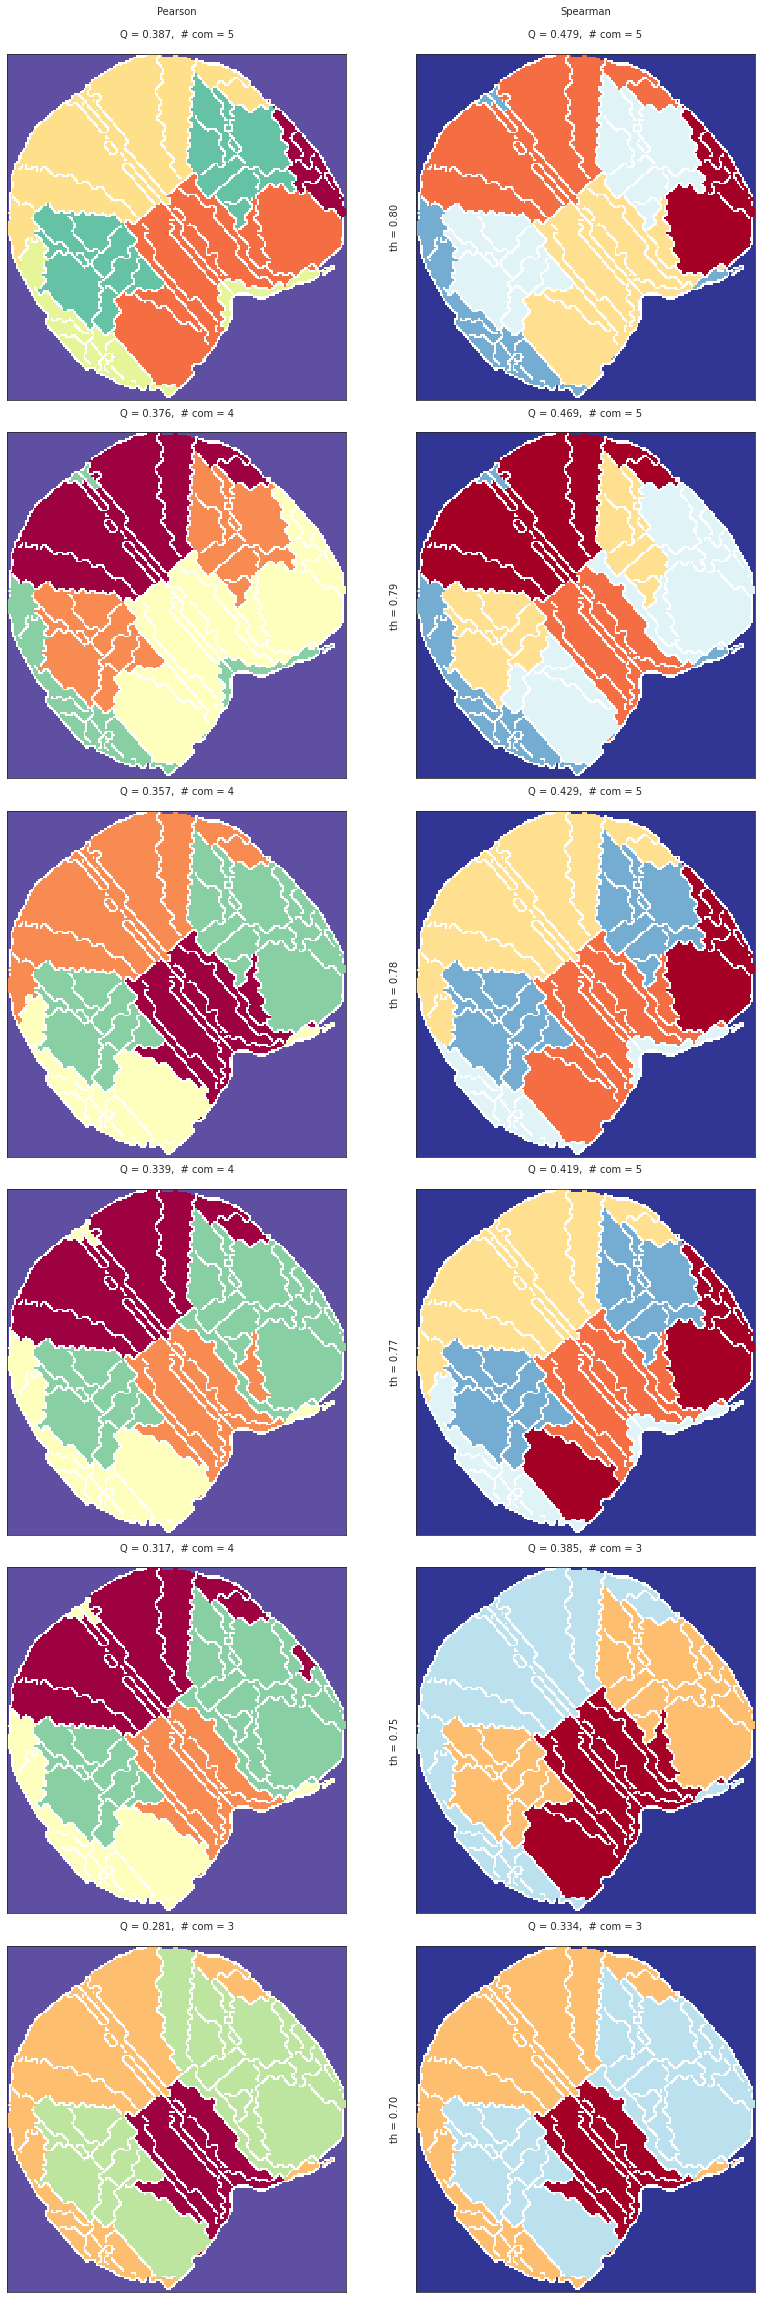

In [226]:
_ = plot_leiden_communities(
    pearson=corrs['pearson'],
    spearman=corrs['spearman'],
    atlas=load['atlas'],
    contour=atls_org['contour'],
    figsize=(12, 32),
    colorbar=False,
)

## Effect of bandpassing on weight distribution

In [284]:
num_regions = len(atls_org['regions'])
order = 2

n = 40
lowcut = np.linspace(0.0, 4, n+1)
lowcut = [item + 1e-3 for item in lowcut]
highcut = [item + 4/n for item in lowcut]

dict_list = []

for (l, h) in tqdm(zip(lowcut, highcut), total=n+1):
    df = pd.DataFrame()
    for run in [1, 3, 5, 7]:
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )

        # bandpass
        ca_bp = {
            k: apply_bandpass(
                x=v,
                fs=config.ca_fs,
                lowcut=l,
                highcut=h,
                order=order,
            ) for k, v in _load['ca'].items()
        }

        # normalize
        mean = np.mean([item.mean() for item in ca_bp.values()])
        sd = np.mean([item.std() for item in ca_bp.values()])
        ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
        df = pd.concat([df, pd.DataFrame.from_dict(ca_bp_n)])

    corrs = get_corrs(df, thresholds=[])
    w = np.concatenate((corrs['pearson_corr'].flatten(), corrs['spearman_corr'].flatten()))
    data_dict = {
        'tag': ['bp'] * 2 * num_regions ** 2,
        'l': [np.round(l, decimals=3)] * 2 * num_regions ** 2,
        'h': [np.round(h, decimals=3)] * 2 * num_regions ** 2,
        'lbl': ['pearson'] * num_regions ** 2 + ['spearman'] * num_regions ** 2,
        'w': w,
    }
    dict_list.append(data_dict)

results = pd.DataFrame.from_dict(merge_dicts(dict_list))
results.w = results.w.replace({0.0 :np.nan})

  0%|          | 0/41 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

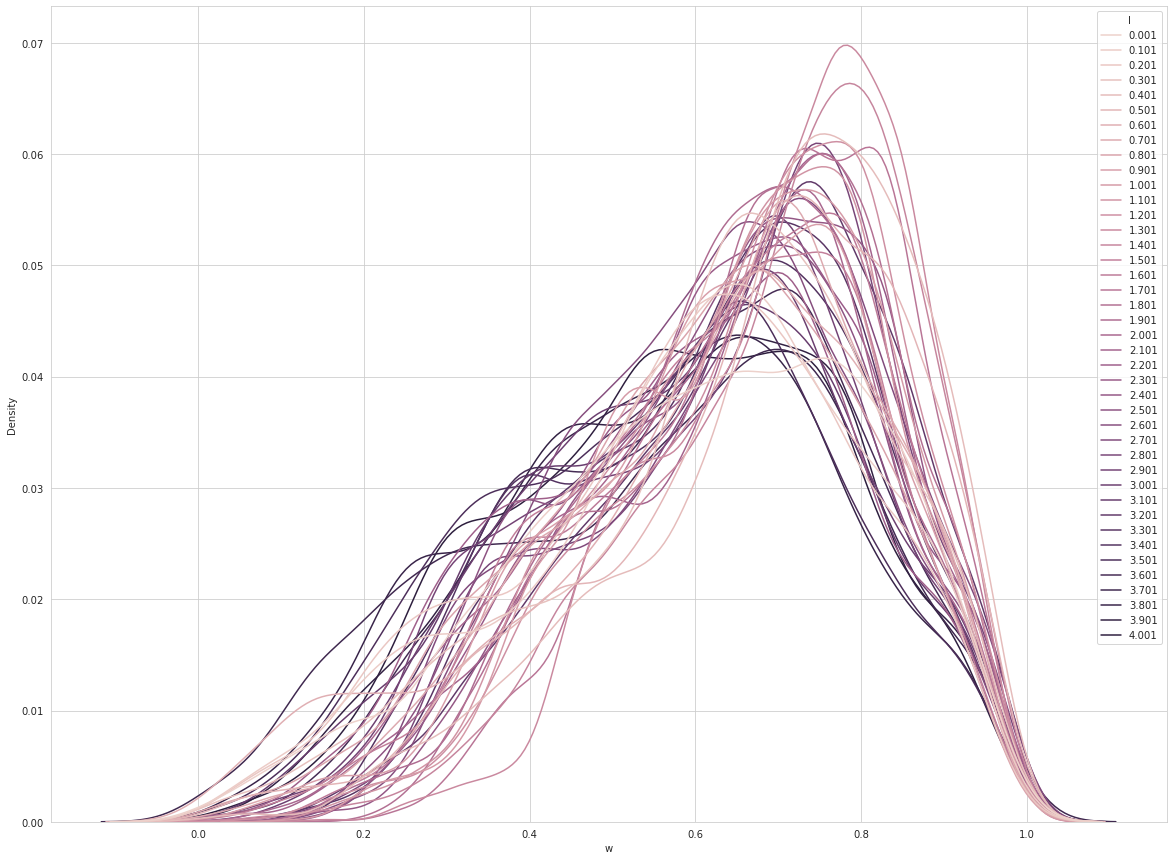

In [285]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 15))

selected_df = results.loc[results.lbl == 'spearman']
sns.kdeplot(data=results, x='w', hue='l', alpha=0.7)
plt.show()

In [303]:
num_regions = len(atls_org['regions'])
order = 2

n = 8
lowcut = np.linspace(0.0, 4, n+1)
highcut = [item + 4/n for item in lowcut]
lowcut = [item + 1e-3 for item in lowcut]

dict_list = []

for (l, h) in tqdm(zip(lowcut, highcut), total=n+1):
    df = pd.DataFrame()
    for run in [1, 3, 5, 7]:
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )

        # bandpass
        ca_bp = {
            k: apply_bandpass(
                x=v,
                fs=config.ca_fs,
                lowcut=l,
                highcut=h,
                order=order,
            ) for k, v in _load['ca'].items()
        }

        # normalize
        mean = np.mean([item.mean() for item in ca_bp.values()])
        sd = np.mean([item.std() for item in ca_bp.values()])
        ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
        df = pd.concat([df, pd.DataFrame.from_dict(ca_bp_n)])

    corrs = get_corrs(df, thresholds=[])
    w = np.concatenate((corrs['pearson_corr'].flatten(), corrs['spearman_corr'].flatten()))
    data_dict = {
        'tag': ['bp'] * 2 * num_regions ** 2,
        'l': [np.round(l, decimals=3)] * 2 * num_regions ** 2,
        'h': [np.round(h, decimals=3)] * 2 * num_regions ** 2,
        'lbl': ['pearson'] * num_regions ** 2 + ['spearman'] * num_regions ** 2,
        'w': w,
    }
    dict_list.append(data_dict)

results = pd.DataFrame.from_dict(merge_dicts(dict_list))
results.w = results.w.replace({0.0 :np.nan})

  0%|          | 0/9 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

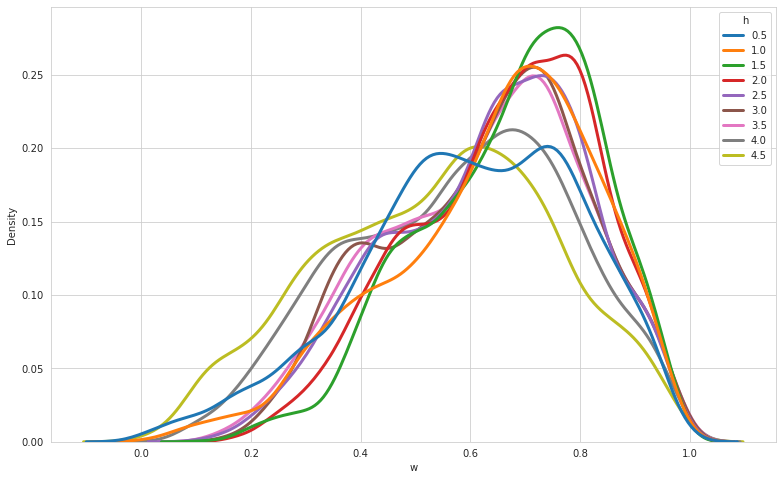

In [307]:
sns.set_style('whitegrid')
plt.figure(figsize=(13, 8))

palette = sns.color_palette('tab10', n_colors=n+1)
selected_df = results.loc[results.lbl == 'spearman']
sns.kdeplot(data=results, x='w', hue='h', palette=palette, lw=3, alpha=0.6)
plt.show()

In [308]:
lowcut, highcut

([0.001, 0.501, 1.001, 1.501, 2.001, 2.501, 3.001, 3.501, 4.001],
 [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5])

In [318]:
num_regions = len(atls_org['regions'])
order = 2

bands = [
    (0.001, 1.), (0.001, 2.), (0.001, 3.), (0.001, 4.),
    (0.01, 1.), (0.01, 2.), (0.01, 3.), (0.01, 4.),
    (0.1, 1.), (0.1, 2.), (0.1, 3.), (0.1, 4.),
]

dict_list = []

for (l, h) in tqdm(bands):
    df = pd.DataFrame()
    for run in [1, 3, 5, 7]:
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )

        # bandpass
        ca_bp = {
            k: apply_bandpass(
                x=v,
                fs=config.ca_fs,
                lowcut=l,
                highcut=h,
                order=order,
            ) for k, v in _load['ca'].items()
        }

        # normalize
        mean = np.mean([item.mean() for item in ca_bp.values()])
        sd = np.mean([item.std() for item in ca_bp.values()])
        ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
        df = pd.concat([df, pd.DataFrame.from_dict(ca_bp_n)])

    corrs = get_corrs(df, thresholds=[])
    w = np.concatenate((corrs['pearson_corr'].flatten(), corrs['spearman_corr'].flatten()))
    data_dict = {
        'tag': ['bp'] * 2 * num_regions ** 2,
        'band': ['{:.3f}-{:.3f}'.format(l, h)] * 2 * num_regions ** 2,
        'lbl': ['pearson'] * num_regions ** 2 + ['spearman'] * num_regions ** 2,
        'w': w,
    }
    dict_list.append(data_dict)

results = pd.DataFrame.from_dict(merge_dicts(dict_list))
results.w = results.w.replace({0.0 :np.nan})

  0%|          | 0/12 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

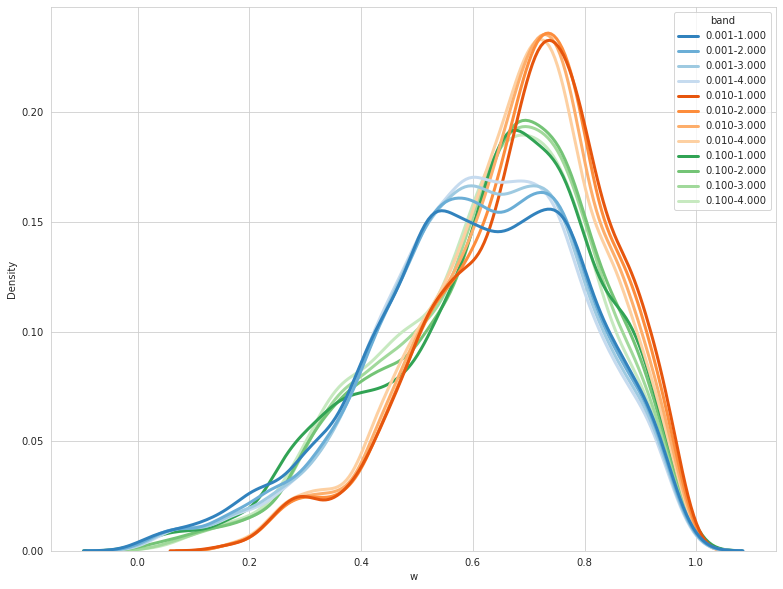

In [320]:
sns.set_style('whitegrid')
plt.figure(figsize=(13, 10))

palette = sns.color_palette('tab20c', n_colors=len(bands))
selected_df = results.loc[results.lbl == 'spearman']
sns.kdeplot(data=results, x='w', hue='band', palette=palette, lw=3, alpha=0.6)
plt.show()

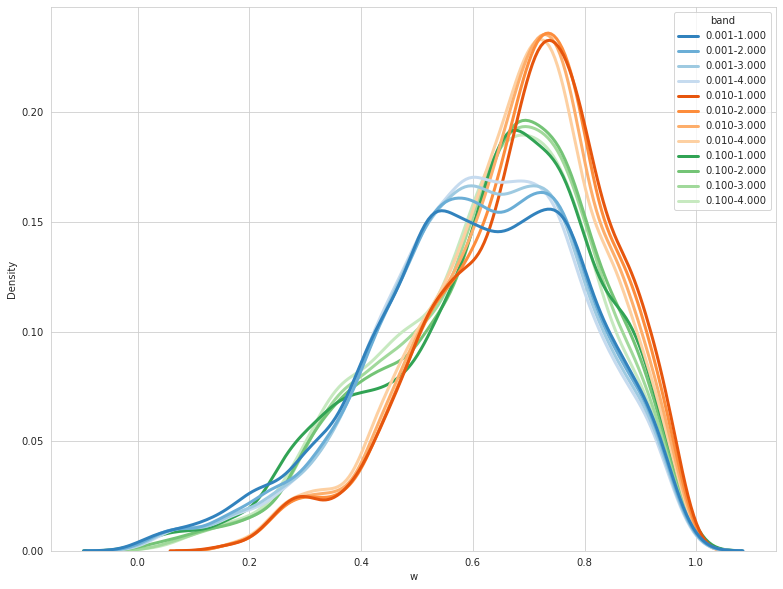

In [321]:
sns.set_style('whitegrid')
plt.figure(figsize=(13, 10))

palette = sns.color_palette('tab20c', n_colors=len(bands))
selected_df = results.loc[results.lbl == 'pearson']
sns.kdeplot(data=results, x='w', hue='band', palette=palette, lw=3, alpha=0.6)
plt.show()

### Combine data across sessions

In [355]:
regions = {}

subject = 6
run = 1

for session in [1, 2, 3]: 
    _load = load_organized_data(
        folder='atlas-allen_unfiltered_unnormalized',
        config=config,
        subject=subject,
        session=session,
        run=run,
    )
    _atlsorg = organize_atlas(_load)
    regions[session] = _atlsorg['regions']
    
common_regions = list(set.intersection(*[set(reg_dict.keys()) for reg_dict in regions.values()]))
len(common_regions)

59

In [349]:
num_regions = len(common_regions)
order = 2

bands = [
    (0.001, 1.), (0.001, 2.), (0.001, 3.), (0.001, 4.),
    (0.01, 1.), (0.01, 2.), (0.01, 3.), (0.01, 4.),
    (0.1, 1.), (0.1, 2.), (0.1, 3.), (0.1, 4.),
]

dict_list = []

for (l, h) in tqdm(bands):
    df = pd.DataFrame()
    for session in [1, 2, 3]:
        for run in [1, 3, 5, 7]:
            _load = load_organized_data(
                folder='atlas-allen_unfiltered_unnormalized',
                config=config,
                subject=subject,
                session=session,
                run=run,
            )
            
            for k, v in _load['ca'].items():
                if np.isnan(v).sum():
                    print(session, run, k)

            # bandpass
            ca_bp = {
                k: apply_bandpass(
                    x=v,
                    fs=config.ca_fs,
                    lowcut=l,
                    highcut=h,
                    order=order, )
                for k, v in _load['ca'].items()
            }

            # normalize
            mean = np.mean([item.mean() for item in ca_bp.values()])
            sd = np.mean([item.std() for item in ca_bp.values()])
            ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
            df = pd.concat([df, pd.DataFrame.from_dict(ca_bp_n)])

    corrs = get_corrs(df.loc[:, common_regions], thresholds=[])
    w = np.concatenate((corrs['pearson_corr'].flatten(), corrs['spearman_corr'].flatten()))
    data_dict = {
        'tag': ['bp'] * 2 * num_regions ** 2,
        'band': ['{:.3f}-{:.3f}'.format(l, h)] * 2 * num_regions ** 2,
        'lbl': ['pearson'] * num_regions ** 2 + ['spearman'] * num_regions ** 2,
        'w': w,
    }
    dict_list.append(data_dict)

results = pd.DataFrame.from_dict(merge_dicts(dict_list))
results.w = results.w.replace({0.0 :np.nan})

  0%|          | 0/12 [00:00<?, ?it/s]

...merging dicts: 0it [00:00, ?it/s]

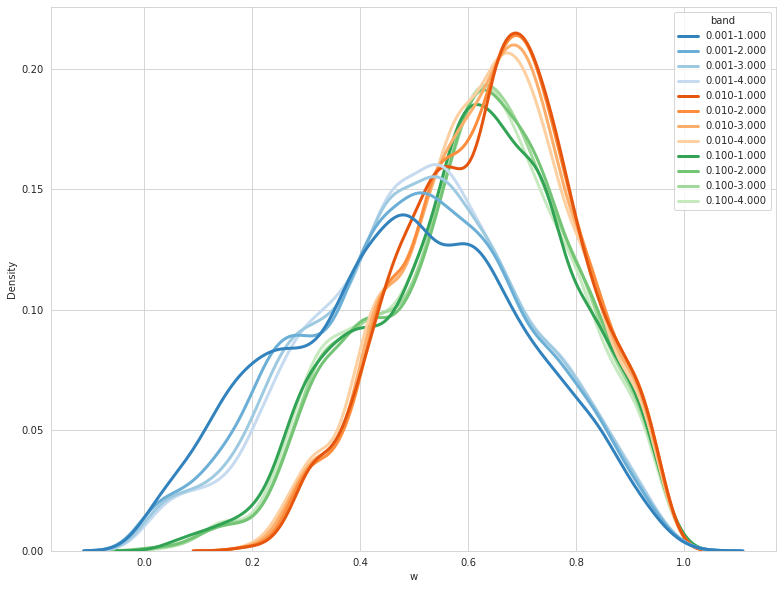

In [350]:
sns.set_style('whitegrid')
plt.figure(figsize=(13, 10))

palette = sns.color_palette('tab20c', n_colors=len(bands))
selected_df = results.loc[results.lbl == 'spearman']
sns.kdeplot(data=results, x='w', hue='band', palette=palette, lw=3, alpha=0.6)
plt.show()

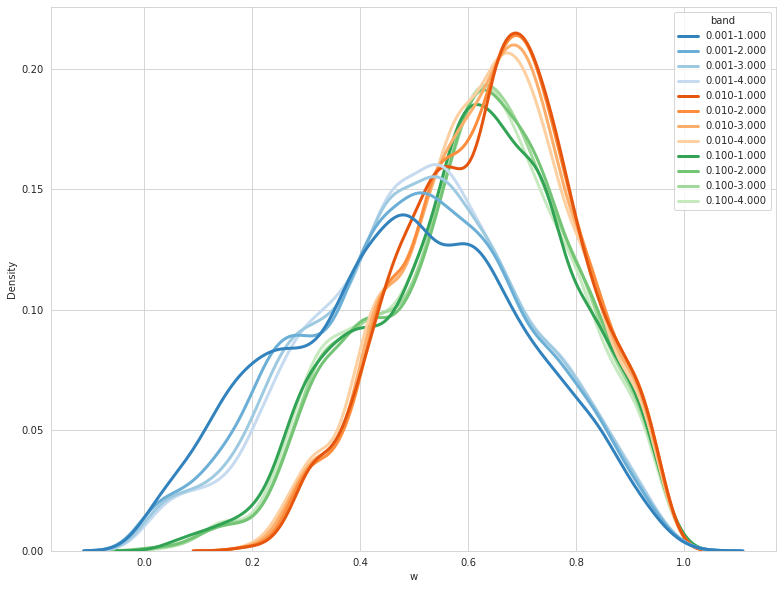

In [351]:
sns.set_style('whitegrid')
plt.figure(figsize=(13, 10))

palette = sns.color_palette('tab20c', n_colors=len(bands))
selected_df = results.loc[results.lbl == 'pearson']
sns.kdeplot(data=results, x='w', hue='band', palette=palette, lw=3, alpha=0.6)
plt.show()

### Combine all data

In [359]:
run = 1
regions = {}
for subject in range(1, config.num_subjects+1):
    for session in range(1, config.num_sessions+1):
        _load = load_organized_data(
            folder='atlas-allen_unfiltered_unnormalized',
            config=config,
            subject=subject,
            session=session,
            run=run,
        )
        if _load is None:
            continue
        _atlsorg = organize_atlas(_load)
        key = 'sub-SLC{:02d}_ses-{:d}'.format(subject, session)
        regions[key] = _atlsorg['regions']
        print(key, len(_atlsorg['regions']))

common_regions = list(set.intersection(*[set(reg_dict.keys()) for reg_dict in regions.values()]))
len(common_regions)

sub-SLC01_ses-1 66
sub-SLC01_ses-2 64
sub-SLC01_ses-3 59
sub-SLC02_ses-1 57
sub-SLC02_ses-2 69
sub-SLC02_ses-3 61
sub-SLC03_ses-2 66
sub-SLC03_ses-3 61
sub-SLC04_ses-1 60
sub-SLC04_ses-2 55
sub-SLC04_ses-3 55
sub-SLC05_ses-1 57
sub-SLC05_ses-2 63
sub-SLC05_ses-3 59
sub-SLC06_ses-1 61
sub-SLC06_ses-2 62
sub-SLC06_ses-3 60
sub-SLC07_ses-1 65
sub-SLC07_ses-2 66
sub-SLC07_ses-3 59
sub-SLC08_ses-1 63
sub-SLC08_ses-2 61
sub-SLC08_ses-3 53
sub-SLC09_ses-1 56
sub-SLC09_ses-2 53
sub-SLC09_ses-3 64
sub-SLC10_ses-1 61
sub-SLC10_ses-2 60


46

In [360]:
num_regions = len(common_regions)
order = 2

bands = [
    (0.001, 1.), (0.001, 2.), (0.001, 3.), (0.001, 4.),
    (0.01, 1.), (0.01, 2.), (0.01, 3.), (0.01, 4.),
    (0.1, 1.), (0.1, 2.), (0.1, 3.), (0.1, 4.),
]

dict_list = []

for (l, h) in tqdm(bands):
    df = pd.DataFrame()
    for subject in range(1, config.num_subjects+1):
        for session in range(1, config.num_sessions+1):
            for run in [1, 3, 5, 7]:
                cond_1 = subject == 3 and session == 2 and run in [2, 6]
                cond_2 = subject == 7 and session == 2 and run in [2, 7]
                if cond_1 or cond_2:
                    continue
    
                _load = load_organized_data(
                    folder='atlas-allen_unfiltered_unnormalized',
                    config=config,
                    subject=subject,
                    session=session,
                    run=run,
                )
                if _load is None:
                    continue

                for k, v in _load['ca'].items():
                    if np.isnan(v).sum():
                        print(session, run, k)

                # bandpass
                ca_bp = {
                    k: apply_bandpass(
                        x=v,
                        fs=config.ca_fs,
                        lowcut=l,
                        highcut=h,
                        order=order, )
                    for k, v in _load['ca'].items()
                }

                # normalize
                mean = np.mean([item.mean() for item in ca_bp.values()])
                sd = np.mean([item.std() for item in ca_bp.values()])
                ca_bp_n = {k: (v - mean) / sd for k, v in ca_bp.items()}
                df = pd.concat([df, pd.DataFrame.from_dict(ca_bp_n)])

    corrs = get_corrs(df.loc[:, common_regions], thresholds=[])
    w = np.concatenate((corrs['pearson_corr'].flatten(), corrs['spearman_corr'].flatten()))
    data_dict = {
        'tag': ['bp'] * 2 * num_regions ** 2,
        'band': ['{:.3f}-{:.3f}'.format(l, h)] * 2 * num_regions ** 2,
        'lbl': ['pearson'] * num_regions ** 2 + ['spearman'] * num_regions ** 2,
        'w': w,
    }
    dict_list.append(data_dict)

results = pd.DataFrame.from_dict(merge_dicts(dict_list))
results.w = results.w.replace({0.0 :np.nan})

  0%|          | 0/12 [00:00<?, ?it/s]

7 2 7
7 2 7
7 2 7
7 2 7
7 2 7
7 2 7
7 2 7
7 2 7
7 2 7
7 2 7
7 2 7
7 2 7


...merging dicts: 0it [00:00, ?it/s]

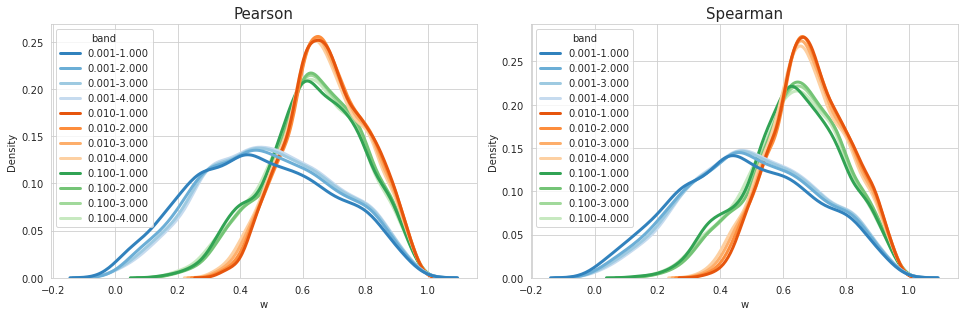

In [369]:
sns.set_style('whitegrid')
palette = sns.color_palette('tab20c', n_colors=len(bands))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(13.5, 4.5))

selected_df = results.loc[results.lbl == 'pearson']
sns.kdeplot(data=selected_df, x='w', hue='band', palette=palette, lw=3, alpha=0.6, ax=ax0)
ax0.set_title('Pearson', fontsize=15)

selected_df = results.loc[results.lbl == 'spearman']
sns.kdeplot(data=selected_df, x='w', hue='band', palette=palette, lw=3, alpha=0.6, ax=ax1)
ax1.set_title('Spearman', fontsize=15)

fig.tight_layout()
plt.show()

## Network measures